<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# Introduction

I'll be looking at a variety of stocks, and various factors that may correlate with their prices.

The key to finding low-hanging fruit here would be to identify companies/industries whose historical prices were already known to be strongly correlated with some small set of factors.  A question arises as to whether it would be preferred to seek stocks that show little volatility in price, as making more conservative (i.e., low-signal) estimates of changes would be simpler: if widgets are always $10/pound, your 'predictor' is anything that outputs no substantial change.  Alternatively, you could propose that a stock with a lot of fluctuation in price is a better opportunity to make money in the short term, **IF** you can manage to predict its future price with accuracy.

Siraj's example using a tech stock offers a potentially variable price, although choosing a large, well-established company (large market capitalization) moderates this compared to a small, obscure, emerging company's stock (small market capitalization).  His predictor, as NYTimes headlines, is extremely variable and ephemeral.

Ideally, of course, to make such a predictor useful, you would also require that its variance slightly *precedes* that of the stock in question in time; many correlations may be apparent simultaneously, but unless you have time to use that information to buy or sell a stock, it won't help.  A final wish might be that the relationship is not well known or leveraged by the general public; you want your hot new tool to be exclusive.  Such criteria are not really imposed in this exercise, however.

## Candidate Predictors

Candidate predictors (general economy; global, conservative):
- U.S. Fed interest rate
- U.S. Unemployment rate
- Price of baseline commodities ([oil](https://www.brookings.edu/blog/ben-bernanke/2016/02/19/the-relationship-between-stocks-and-oil-prices/) is a well-known example)
- A general market index (DJIA/Nasdaq)
- Alternative investment markets: bonds, [gold](http://www.marketwatch.com/story/inverse-relationship-between-gold-stocks-has-never-been-this-extreme-2016-08-23)
- Relative currency strength: generally, a weak dollar can mean poor stock market performance, although [this is highly dependent upon market sector](https://www.forbes.com/sites/laurengensler/2014/10/01/what-a-stronger-dollar-means-for-stocks/#7cc9e37f241a)

Candidate predictors (specific, short-term):
- [Google search trends](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0040014)
- [Twitter trends/sentiment](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0138441)
    - Note: Twitter data are typically very short-lived from official channels, but apparently [historical caches do exist](https://www.quora.com/Is-there-an-archive-that-tracks-Twitter-Trending-Topics-historically).
- [Trading news aggregated by financial sites](https://www.quora.com/What-is-the-best-and-most-instantaneous-financial-news-aggregator)

Whatever predictor you choose, ideally grab a bunch to try, and [test correlations](http://www.investopedia.com/articles/active-trading/121014/stock-correlation-strategy-effective.asp) with stock prices over the interval in question.  Then choose the strongest correlations (positive or negative) as the 3 features you want to train on.

# Getting Stock Price Data

Let's just try a few of these.  First, getting stock price data programmatically; [a few options](https://www.quora.com/From-which-Web-site-is-it-easiest-to-scrape-stock-data-for-free).  

## Google Finance API

[Another discussion](https://stackoverflow.com/questions/9740116/programmatic-access-to-detailed-historical-financial-data) offers a [Python script](https://gist.github.com/knoguchi/6952087) for grabbing from off of Google finance.  I'll try that now.

    # Programmatic acces:
    from google_finance import GoogleFinance
    aapl = GoogleFinance('NASDAQ', 'AAPL')
    print aapl.income_statement()

In [2]:
gist_pc_path = r'C:\Users\DMacKellar\Dropbox\Coding\\
Python\Sirajology\20170908_Stock_market_prediction'
gist_mac_path = '/Users/drew/Dropbox/Coding/Python/\
Sirajology/20170908_Stock_market_prediction'

import sys
sys.path.insert(0, gist_pc_path)
# sys.path.insert(0, gist_mac_path)

from gistfile import GoogleFinance

In [3]:
import pandas as pd

dir(GoogleFinance)
dir(GoogleFinance('NASDAQ', 'AMZN'))
dir(GoogleFinance('NASDAQ', 'AMZN')._get_from_google())
aapl = GoogleFinance('NASDAQ', 'AAPL')

aapl_inc = pd.DataFrame(list(aapl.income_statement(term='interim')))
aapl_inc.head()

""


Ah, ok, I see now; that script was written specifically to retrieve statements **beyond just stock prices**: income statements, balance sheets, and cash flows.  These *could* be useful in predicting stock prices, but may be kind of against the general spirit of this exercise, as an advanced approach in leveraging general information via machine learning.  I'll ignore these for now and get back to retrieving just prices.

## Google Finance Client API

Here.  [This](https://pypi.python.org/pypi/googlefinance.client/1.3.0) looks promising: a google finance Python API.

Usage is:

    from googlefinance.client import get_price_data, get_prices_data, get_prices_time_data

    # Dow Jones
    param = {
        'q': ".DJI", # Stock symbol (ex: "AAPL")
        'i': "86400", # Interval size in seconds ("86400" = 1 day intervals)
        'x': "INDEXDJX", # Stock exchange symbol on which stock is traded (ex: "NASD")
        'p': "1Y" # Period (Ex: "1Y" = 1 year)
    }
    # get price data (return pandas dataframe)
    df = get_price_data(param)

In [4]:
from googlefinance.client import get_closing_data, get_price_data

params = [
    # Dow Jones
    {
        'q': ".DJI",
        'x': "INDEXDJX",
    },
    # NYSE COMPOSITE (DJ)
    {
        'q': "NYA",
        'x': "INDEXNYSEGIS",
    },
    # S&P 500
    {
        'q': ".INX",
        'x': "INDEXSP",
    },
    # Nasdaq
    {
        'q': '.IXIC',
        'x': 'INDEXNASDAQ'
    }
]

period = '10Y'
market_indices = get_closing_data(params, period)
rename_dict = {'.DJI': 'DJIA', 'NYA': 'NYSE Composite', 
               '.INX': 'S&P500', '.IXIC': 'Nasdaq'}
market_indices.rename(columns=rename_dict, inplace=True)
market_indices.head()

,DJIA,NYSE Composite,S&P500,Nasdaq
2007-11-01,13567.87,10022.08,1508.44,2794.83
2007-11-02,13595.10,10052.26,1509.65,2810.38
2007-11-05,13543.40,9958.82,1502.17,2795.18
2007-11-06,13660.94,10102.41,1520.27,2825.18
2007-11-07,13300.02,9830.15,1475.62,2748.76


Ok, cool; that will work.  The 'get_prices_data' method also returns a pandas dataframe, but with open/high/low/volume floats as well.  Closing is plenty for me.

---

# Getting Predictor Data

Other notes:
- Crude oil is tracked in the Nasdaq as 'WTI'
- Gold (specifically, the Commodity Futures Price for gold) is tracked in the Nasdaq as 'GLD'.  There are also [several other symbols](http://etfdb.com/index/gold-bullion/) that track other exchanges for gold.
- ?Apparently? the Fed Interest Rate [has a stock ticker (or analog)](https://www.bloomberg.com/quote/FDFD:IND) under 'FDFD'
- The Fed rate probably shouldn't be rolled in with stock prices, though, since it's a percentage, not a dollar price.  
    - The better access point is the St. Louis Fed's [FRED](https://fred.stlouisfed.org/series/DFF) service, which allows historical data to be downloaded for daily-not-seasonally-adjusted percentages going back to 1954.  
    - I downloaded the 10-year and all-time records for Fed rates on the PC as DFF.csv and DFF(1).csv, respectively to:
        - C:\Users\DMacKellar\Dropbox\Coding\Python\Sirajology\20170908_Stock_market_prediction\Data
- U.S. Unemployment rate historical data are also available from FRED; they're monthly, so I'll have to use pandas to interpolate missing data.  I downloaded to:
    - C:\Users\DMacKellar\Dropbox\Coding\Python\Sirajology\20170908_Stock_market_prediction\Data\unemployment_rate.csv
- Similarly, FRED offers various measures of relative purchasing power of the U.S. Dollar; I downloaded daily data for the Broad Index (measuring relative to a large number of global trading partners' currencies):
    - C:\Users\DMacKellar\Dropbox\Coding\Python\Sirajology\20170908_Stock_market_prediction\Data\DTWEXB.csv
    
- Google Trends has an [unofficial Python API](https://pypi.python.org/pypi/pytrends/4.2.2) contributed by Hogue and DeWilde, which allows searching back five years.

In [5]:
fed_pc_path = r'C:\Users\DMacKellar\Dropbox\Coding\\
Python\Sirajology\20170908_Stock_market_prediction\Data\DFF.csv'
fed_mac_path = '/Users/drew/Dropbox/Coding/Python/\
Sirajology/20170908_Stock_market_prediction/Data/DFF.csv'

fed_rates = pd.DataFrame.from_csv(fed_pc_path)
# fed_rates = pd.DataFrame.from_csv(fed_mac_path)
fed_rates.rename(columns={'DFF': 'Fed_rate(%)'}, inplace=True)
fed_rates.head()

,Fed_rate(%)
DATE,
2007-09-08,4.86
2007-09-09,4.86
2007-09-10,5.07
2007-09-11,5.06
2007-09-12,5.18


In [6]:
us_unemployment_pc_path = r'C:\Users\DMacKellar\Dropbox\Coding\Python\\
Sirajology\20170908_Stock_market_prediction\Data\unemployment_rate.csv'
us_unemployment_mac_path = '/Users/drew/Dropbox/Coding/Python/\
Sirajology/20170908_Stock_market_prediction/Data/unemployment_rate.csv'

us_unemployment = pd.DataFrame.from_csv(us_unemployment_pc_path)
# us_unemployment = pd.DataFrame.from_csv(us_unemployment_mac_path)
us_unemployment.rename(columns={'UNRATE': 'US Unemployment(%)'}, inplace=True)
us_unemployment.head()

,US Unemployment(%)
DATE,
2007-08-01,4.6
2007-09-01,4.7
2007-10-01,4.7
2007-11-01,4.7
2007-12-01,5.0


In [7]:
us_dollar_path_pc = r'C:\Users\DMacKellar\Dropbox\Coding\Python\\
Sirajology\20170908_Stock_market_prediction\Data\DTWEXB.csv'
us_dollar_path_mac = '/Users/drew/Dropbox/Coding/Python/\
Sirajology/20170908_Stock_market_prediction/Data/DTWEXB.csv'

us_dollar = pd.DataFrame.from_csv(us_dollar_path_pc)
# us_dollar = pd.DataFrame.from_csv(us_dollar_path_mac)
us_dollar.rename(columns={'DTWEXB': 'USD Strength'}, inplace=True)
us_dollar.head()

,USD Strength
DATE,
2007-09-10,102.9564
2007-09-11,102.6477
2007-09-12,102.3519
2007-09-13,102.3260
2007-09-14,102.4094


Standard&Poor maintain an [Aggregate Bond Index](https://us.spindices.com/indices/fixed-income/sp-us-aggregate-bond-index) for 
- "U.S. treasuries, quasi-governments, corporates, taxable municipal bonds, supranational and non-U.S. government debentures, covered bonds, and residential mortgage pass-throughs"
as well as [indices for U.S. Treasury bonds](http://us.spindices.com/indices/fixed-income/sp-us-treasury-bond-index) maturing in different time intervals.  I downloaded them all as xls files to the same Data folder as the Fed rates.
    - Unfortunately, I couldn't quite get the `pd.read_excel()` method to work the way I wanted, so I manually saved the files to csv format, and will use those.

In [8]:
import re
import os
from functools import reduce
from datetime import datetime

data_dir_pc = r'C:\Users\DMacKellar\Dropbox\Coding\\
Python\Sirajology\20170908_Stock_market_prediction\Data'
data_dir_mac = '/Users/drew/Dropbox/Coding/Python/\
Sirajology/20170908_Stock_market_prediction/Data/'

bonds_pattern = re.compile('bonds.*\.csv')
bonds_df = pd.DataFrame()
dfs = {}

for file in os.listdir(data_dir_pc):
# for file in os.listdir(data_dir_mac):
        if re.match(bonds_pattern, file):
            file_path = os.path.join(data_dir_pc, file)
#             file_path = os.path.join(data_dir_mac, file)
            dfs[file] = pd.read_csv(file_path, header=6, usecols=[0,1], 
                                         index_col=0, parse_dates=True, 
                                         infer_datetime_format=True,
                                         encoding='latin1',
                                         skip_blank_lines=True)
            dfs[file].dropna(inplace=True)
            dfs[file].index = pd.to_datetime(dfs[file].index, format='%m/%d/%Y')
            dfs[file].sort_index(inplace=True)

bonds_df = reduce(lambda x, y: x.join(y, how='outer'), dfs.values())

In [9]:
dfs['bonds_0-1yr.csv'].index
bonds_df.head()
# bonds_df['S&P U.S. Treasury Bond 1-5 Year Index'].value_counts().sum()
# bonds_df['S&P U.S. Treasury Bond 1-5 Year Index'].isnull().sum()

,S&P U.S. Treasury Bond 0-1 Year Index,S&P U.S. Treasury Bond 1-3 Year Index,S&P U.S. Treasury Bond 1-5 Year Index,S&P U.S. Treasury Bond 3-5 Year Index,S&P U.S. Treasury Bond 5-7 Year Index,S&P U.S. Treasury Bond Index
Effective date,,,,,,
2007-08-15,NaN,NaN,278.71,NaN,NaN,NaN
2007-08-31,225.92,264.86,NaN,313.96,339.79,306.89
2007-09-04,225.90,264.99,NaN,314.02,339.85,306.89
2007-09-05,226.01,265.63,NaN,315.42,341.71,308.16
2007-09-06,225.99,265.39,NaN,314.99,341.20,307.79


Man, that took *forever* to figure out.  I thought I'd be able to just append all of the incoming files' data to a single DataFrame within the '`for`' loop, but it kept complaining about indices not lining up, so I set them to individual objects within a dict.  But then I still couldn't find the right way to arrange the indices so that it would use any of the `pd.merge, pd.join,` or `pd.concat` methods.  I spent a couple of uninspired hours just to get that freaking df together; hopefully it'll serve as a useful template for adding on other predictors, though.

In [110]:
from googlefinance.client import get_closing_data, get_price_data

params = [
    # SPDR Gold Trust
    {
        'q': "GLD",
        'x': "NASD"
    },
    # Crude oil
    {
        'q': "WTI",
        'x': "NYMEX"
    },
    # Real Estate
    {
        'q': "VNQ",
        'x': "NYSEARCA"
    },
    # Hedge Funds
    {
        'q': 'QAI',
        'x': 'NYSEARCA'
    }
]

period = '10Y'
alt_indices = get_closing_data(params, period)
rename_dict = {'GLD': 'Gold', 'WTI': 'Oil',
               'VNQ': 'Real Estate', 'QAI': 'Hedge Funds'}
alt_indices.rename(columns=rename_dict, inplace=True)
alt_indices.head()

,Gold,Oil,Real Estate,Hedge Funds
2007-11-01,77.93,26.71,69.55,NaN
2007-11-02,79.83,26.75,68.56,NaN
2007-11-05,79.75,26.49,67.57,NaN
2007-11-06,81.43,26.33,68.42,NaN
2007-11-07,82.24,27.71,66.29,NaN


In [111]:
# %who
predictors_list = [fed_rates, us_dollar, us_unemployment, 
                   bonds_df, market_indices, alt_indices]

predictors_df = reduce(lambda x, y: x.join(y, how='outer'), predictors_list)
predictors_df.head()

,Fed_rate(%),USD Strength,US Unemployment(%),S&P U.S. Treasury Bond 0-1 Year Index,S&P U.S. Treasury Bond 1-3 Year Index,S&P U.S. Treasury Bond 1-5 Year Index,S&P U.S. Treasury Bond 3-5 Year Index,S&P U.S. Treasury Bond 5-7 Year Index,S&P U.S. Treasury Bond Index,DJIA,NYSE Composite,S&P500,Nasdaq,Gold,Oil,Real Estate,Hedge Funds
2007-08-01,NaN,NaN,4.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-08-15,NaN,NaN,NaN,NaN,NaN,278.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-08-31,NaN,NaN,NaN,225.92,264.86,NaN,313.96,339.79,306.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-09-01,NaN,NaN,4.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-09-04,NaN,NaN,NaN,225.90,264.99,NaN,314.02,339.85,306.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Some of these values have earlier start dates than others, probably because I downloaded the data at different dates.  But many will have '`NaN`' values for many of the entries, because the indices are mostly daily, but several of the measures are only reported weekly/monthly/etc.  For those with different periodicities (like the unemployment rate, the treasury bond indices, etc.), we can probably infer that they remained at the same rate until updated.  So probably the best strategy would be to fill NaN values down in the table, then truncate rows that don't contain any data.

After forward filling, though, the predictor 'Hedge Funds' still has 572 missing values.  That's the weakest link, and dropping all other NA from the table would cost us about 1/6th of the rows, so I'll keep the rows containing NaN values in that column in the dataframe.

In [112]:
print(predictors_df.shape)
predictors_df.ffill(axis=0, inplace=True)
predictors_df.dropna(inplace=True, axis=0, subset=predictors_df.columns[:-1])
print(predictors_df.shape)
predictors_df.isnull().sum()
# predictors_df.head()
# predictors_df.columns

(3699, 17)
(3637, 17)


Fed_rate(%)                                0
USD Strength                               0
US Unemployment(%)                         0
S&P U.S. Treasury Bond 0-1 Year Index      0
S&P U.S. Treasury Bond 1-3 Year Index      0
S&P U.S. Treasury Bond 1-5 Year Index      0
S&P U.S. Treasury Bond 3-5 Year Index      0
S&P U.S. Treasury Bond 5-7 Year Index      0
S&P U.S. Treasury Bond Index               0
DJIA                                       0
NYSE Composite                             0
S&P500                                     0
Nasdaq                                     0
Gold                                       0
Oil                                        0
Real Estate                                0
Hedge Funds                              510
dtype: int64

I'm having downstream problems interpreting these predictors because the `USD Strength` contains some values as a just a single period.  Thus the dtype is forced to be '`object`'.  It won't convert easily, so I'll have to drop those values, then convert the remainder of the Series to float32.  In fact, I'll convert the entire df to float32; it seems by far the more common dtype to use in ML.

In [113]:
print(predictors_df.shape)
predictors_df['USD Strength'] = predictors_df['USD Strength'].replace(to_replace='.', value=np.nan)
predictors_df.fillna(method='ffill')
predictors_df = predictors_df.astype(np.float32)
print(predictors_df.shape)

(3637, 17)
(3637, 17)


In [114]:
# Save the predictors data to this point
out_dir_pc = r'C:\Users\DMacKellar\Dropbox\Coding\Python\Sirajology\\
20170908_Stock_market_prediction\Data'

# on PC:
pred_path = os.path.join(out_dir_pc, 'predictors_df')

predictors_df.to_csv(path_or_buf=pred_path)

# Choosing Stocks

Next, which stocks to get to compare to?

## Microsoft Stock

Since Siraj chose Microsoft, and since keeping my results compatible with his will probably yield the best comparison as to how I'm doing, I'll choose that for now, too.

In [77]:
params = [
    # Microsoft stock
    {
        'q': "MSFT",
        'x': "NASDAQ",
    }
]

period = '10Y'
microsoft_stock = get_closing_data(params, period)

In [82]:
microsoft_stock.index
365 * 10

3650

In [78]:
print('microsoft_stock.shape: ', microsoft_stock.shape)
ms_predictors_df = microsoft_stock.join(predictors_df, how='outer')
ms_predictors_df.head()

microsoft_stock.shape:  (2517, 1)


,MSFT,Fed_rate(%),USD Strength,US Unemployment(%),S&P U.S. Treasury Bond 0-1 Year Index,S&P U.S. Treasury Bond 1-3 Year Index,S&P U.S. Treasury Bond 1-5 Year Index,S&P U.S. Treasury Bond 3-5 Year Index,S&P U.S. Treasury Bond 5-7 Year Index,S&P U.S. Treasury Bond Index,DJIA,NYSE Composite,S&P500,Nasdaq,Gold,Oil,Real Estate,Hedge Funds
2007-11-01,37.06,4.59,98.8268,4.7,227.91,268.39,284.53,319.55,346.06,312.21,13567.87,10022.08,1508.44,2794.83,77.93,26.71,69.55,NaN
2007-11-02,37.06,4.28,98.5746,4.7,228.08,269.10,285.53,320.99,347.59,313.31,13595.10,10052.26,1509.65,2810.38,79.83,26.75,68.56,NaN
2007-11-03,NaN,4.28,98.5746,4.7,228.08,269.10,285.53,320.99,347.59,313.31,13595.10,10052.26,1509.65,2810.38,79.83,26.75,68.56,NaN
2007-11-04,NaN,4.28,98.5746,4.7,228.08,269.10,285.53,320.99,347.59,313.31,13595.10,10052.26,1509.65,2810.38,79.83,26.75,68.56,NaN
2007-11-05,36.73,4.29,98.5672,4.7,228.12,269.02,285.33,320.77,347.29,313.09,13543.40,9958.82,1502.17,2795.18,79.75,26.49,67.57,NaN


In [16]:
ms_predictors_df.corr(min_periods=100).iloc[0].sort_values(ascending=False)

MSFT                                     1.000000
Nasdaq                                   0.954468
S&P500                                   0.939809
DJIA                                     0.937620
NYSE Composite                           0.860023
Real Estate                              0.808497
Hedge Funds                              0.742114
S&P U.S. Treasury Bond 5-7 Year Index    0.724655
S&P U.S. Treasury Bond Index             0.714606
S&P U.S. Treasury Bond 3-5 Year Index    0.708797
S&P U.S. Treasury Bond 1-5 Year Index    0.689265
S&P U.S. Treasury Bond 1-3 Year Index    0.672047
S&P U.S. Treasury Bond 0-1 Year Index    0.637529
Fed_rate(%)                              0.081549
Gold                                    -0.048489
Oil                                     -0.564184
US Unemployment(%)                      -0.782157
Name: MSFT, dtype: float64

Ok, so the price of MSFT stock correlates pretty well with the stock market in general (especially the Nasdaq, unsurprisingly), somewhat well with other indices, and somewhat inversely with unemployment.  But how about how the price of MSFT stock does the day *following* any of these other indicators?  To get this, the quickest way would be to lie and say that the date associated with the index in the original MSFT stock df is actually one day *sooner* than it really is.

In [17]:
import datetime

# microsoft_nextday = microsoft_stock.copy().reindex(index=[i-datetime.timedelta(days=1) for i in microsoft_stock.index])
microsoft_nextday = microsoft_stock.copy().shift(periods=-1)
# print(microsoft_stock.iloc[:10] == microsoft_nextday.iloc[1:11])
# print(microsoft_stock.iloc[0], microsoft_nextday.iloc[0])
print(microsoft_stock.head(), '\n', microsoft_nextday.head())

             MSFT
2007-11-01  37.06
2007-11-02  37.06
2007-11-05  36.73
2007-11-06  36.41
2007-11-07  35.52 
              MSFT
2007-11-01  37.06
2007-11-02  36.73
2007-11-05  36.41
2007-11-06  35.52
2007-11-07  34.74


In [18]:
# Recalculate correlation matrix between MSFT stock and
# predictor values from the preceding day
msnxtdy_predictors_df = microsoft_nextday.join(predictors_df, how='outer')
corr1 = ms_predictors_df.corr(min_periods=100).iloc[0]
corr2 = msnxtdy_predictors_df.corr(min_periods=100).iloc[0]

corr2/corr1

MSFT                                     1.000000
Fed_rate(%)                              0.971503
US Unemployment(%)                       0.998911
S&P U.S. Treasury Bond 0-1 Year Index    1.001310
S&P U.S. Treasury Bond 1-3 Year Index    1.001368
S&P U.S. Treasury Bond 1-5 Year Index    1.001348
S&P U.S. Treasury Bond 3-5 Year Index    1.001198
S&P U.S. Treasury Bond 5-7 Year Index    1.001112
S&P U.S. Treasury Bond Index             1.001167
DJIA                                     0.999430
NYSE Composite                           0.999044
S&P500                                   0.999532
Nasdaq                                   0.999702
Gold                                     0.985076
Oil                                      1.001622
Real Estate                              0.999494
Hedge Funds                              0.998845
Name: MSFT, dtype: float64

Ok, so using the next day slightly decreases the correlation between any predictor and its stock price, but not by a whole lot.  Any predictor that showed a high simultaneous correlation would probably be suitable as a basis for buying/selling stock the day *after* the predictor's value is determined.

Ok, so those high-level predictors are ok; particularly the Nasdaq and S&P500 (or, perhaps the U.S. Unemployment rate, in case it would help at all to have a *negative* predictor of performance, albeit a noisier one).  Now, let's try getting a more individualized predictor, specific to the stock.  I'll try collecting data on search trends and tweets regarding `MSFT` stock.


# Stock-specific Predictors

## Microsoft Search Trends

Again, according to the [limited docs](https://github.com/GeneralMills/pytrends) on the `pytrends` API, you need to first call the `.request.TrendReq()` method, then the `.build_payload()` method, passing a specific list of search strings.  Actually, the [example page](https://github.com/GeneralMills/pytrends/blob/master/examples/example.py) may be a better resource to look at.

In [19]:
from pytrends.request import TrendReq
import pytrends

dir(pytrends)
pytrend = pytrends.request.TrendReq(hl='en-US', tz=360)
# kw_list = ['Microsoft', 'MSFT', 'NASDAQ:MSFT', 'Microsoft Stock']
kw_list = ['MSFT', 'Microsoft Stock']
pytrend.build_payload(kw_list, cat=0, timeframe='today 5-y', geo='', gprop='')
interest_over_time_5y = pytrend.interest_over_time()
related_queries_dict = pytrend.related_queries()
print('{}'.format(related_queries_dict))
interest_over_time_5y.head()

{}


,MSFT,Microsoft Stock,isPartial
date,,,
2012-11-04,42,17,False
2012-11-11,49,20,False
2012-11-18,34,14,False
2012-11-25,38,16,False
2012-12-02,37,16,False


In [20]:
print(interest_over_time_5y.shape)
interest_over_time_5y.describe()

(261, 3)


,MSFT,Microsoft Stock
count,261.000000,261.000000
mean,37.210728,18.808429
std,12.327800,5.716515
min,19.000000,9.000000
25%,29.000000,15.000000
50%,34.000000,18.000000
75%,42.000000,21.000000
max,100.000000,48.000000


In [21]:
# from pytrends.request import TrendReq
import pytrends

dir(pytrends)
pytrend = pytrends.request.TrendReq(hl='en-US', tz=360)
# kw_list = ['Microsoft', 'MSFT', 'NASDAQ:MSFT', 'Microsoft Stock']
kw_list = ['MSFT', 'Microsoft Stock']
pytrend.build_payload(kw_list, cat=0, timeframe='2017-06-14 2017-09-14', geo='', gprop='')
interest_over_time_10y = pytrend.interest_over_time()
related_queries_dict = pytrend.related_queries()
print('{}'.format(related_queries_dict))
interest_over_time_10y.head()

{}


,MSFT,Microsoft Stock,isPartial
date,,,
2017-06-14,26,14,False
2017-06-15,24,13,False
2017-06-16,24,12,False
2017-06-17,7,7,False
2017-06-18,5,4,False


In [22]:
print(interest_over_time_10y.shape)
interest_over_time_10y.describe()

(93, 3)


,MSFT,Microsoft Stock
count,93.000000,93.000000
mean,19.688172,11.032258
std,14.004641,4.862124
min,3.000000,3.000000
25%,9.000000,7.000000
50%,20.000000,12.000000
75%,24.000000,13.000000
max,100.000000,31.000000


Ok, I'm starting to get it.  Although Google's own [trends docs page](https://support.google.com/trends/answer/4365533?hl=en&ref_topic=6248052) is a bit ambiguous, the numbers output indicate relative popularity of the search term **among all terms input** over time.  This is why, when I tried the longer list that included '`Microsoft`' as an individual term, the other strings all returned zeroes.  The vast majority of people searching online will be looking for something about how to use MS Office or so forth; very few by comparison will be about the stock price or company news.  So you have to consider your list of input search strings carefully, and avoid any that stray far enough from exactly what you're interested in to introduce noise relative to what you're interested in.

Of course, what I'm interested in is just the term that correlates best with stock price, and that isn't super obvious; people probably look up the stock's price whenever they're strongly interested in buying OR selling.  Something more specific, like a new product release or internal company politics might be more predictive of a directional change in price.

---

## Debugging a Google Trends API

Another point: The API's instructions defaults to a '`5-y`' interval, but the [web interface](https://trends.google.com/trends/explore?date=2007-08-14%202017-09-14&q=microsoft%20stock) clearly permits searching any date range from 2004 to the present.  While the API's example search takes the form '`timeframe='today 5-y`', the URL of a custom web-based search looks like '`date=2007-08-14%202017-09-14`'.  There should be some way to convert the latter into something acceptably by the API.

Ok, I found out that just inputting two dates in a string of the form '`2007-08-14 2017-09-14`' will work.  But surprisingly, the number of rows of the output df actually *de*creases if you go from 5y to 10y of data.  Specifically, it looks like if you request a 10yr period you get back monthly data; if you request a 1yr period you get back weekly data, and if you want daily data you have to request a period of 3 months or less.
[This post](http://www.clintonboys.com/google-trends-scraper/) suggests that Google throttles the output based on the time range specified; if you want daily data you'll have to chop the search into smaller requests and then combine them.

...But that strategy would lose some information.  Specifically, the numbers returned specify the frequency of that term's popularity **over the window of time specified**.  It always rescales to between 1 and 100, and therefore if you ask for multiple 2-month windows, you'll introduce a periodicity to the data such that the term will spike and fall in popularity every two months.  To keep the data scaled properly, I'll have to do just one search for any given timeframe.


...But it looks like the original post that I referenced HAD included some sort of rescaling of the data.  I suppose that, if you know the relative popularity of your search term over a 10 year scale, you can pick a the 10y value of a particular date, find the matching date within the 2-month data, and multiply all dates within that 2-month period by the relative popularity of the term over the 10-year period.  The result may not be perfect, but it should be useable.  I'll try downloading [his script](https://github.com/clintonboys/trendy-scraper/blob/master/gt_scraper_v2.py) and running it here.

...It doesn't work well, because the print statement error shows it to be written for Python 2.  I'll try converting it automatically, using the [2to3](https://docs.python.org/3.0/library/2to3.html) module.  I've confirmed that this is available from the command line on my PC; no issues with having to add it to the PATH.

    cd C:\Users\DMacKellar\Dropbox\Coding\Python\Sirajology\20170908_Stock_market_prediction
    2to3 -w gt_scraper_v2.py
    
Looks like that ran; I'll try again.

In [23]:
gist_path_pc = r'C:\Users\DMacKellar\Dropbox\Coding\\
Python\Sirajology\20170908_Stock_market_prediction'
gist_path_mac = '/Users/drew/Dropbox/Coding/Python/\
Sirajology/20170908_Stock_market_prediction/'

import sys
import site
import importlib
importlib.reload(site)

sys.path.insert(0, gist_path_pc)
# sys.path.insert(0, gist_path_mac)

import gt_scraper_v2_DCM

Unfortunately, it's really meant to be run from the command line; not a lot of support for IPython.  Command line syntax for usage is:

    python gt_scraper_v2.py 2016-01-01 2017-02-18 donald trump

In [24]:
import os
import subprocess

def gt_scraper(predictors_df, mac_pc='mac'):

    gist_pc = os.path.join(gist_path_pc, 'gt_scraper_v2_DCM.py')
    gist_mac = os.path.join(gist_path_mac, 'gt_scraper_v2_DCM.py')

    date_1 = predictors_df.index[0].to_pydatetime().date().strftime('%Y-%m-%d')
    date_2 = predictors_df.index[-1].to_pydatetime().date().strftime('%Y-%m-%d')

    search = 'MSFT'

    if mac_pc == 'pc':
        commands = ['python {} {} {} {}'.format(gist_pc, date_1, date_2, search)]
    elif mac_pc == 'mac':
        commands = ['python {} {} {} {}'.format(gist_pc, date_1, date_2, search)]
    # commands = ['{};{} {} {}'.format(gist_mac, date_1, date_2, search)]

    stdout = subprocess.run(commands, stdout=subprocess.PIPE, 
                       stderr=subprocess.STDOUT, shell=True,
                       check=True)
#     return commands
    return stdout

Hmm, well, I haven't gotten that working with subprocess yet, but running it from the command line seemed to do something, because it returned:

    C:\Users\DMacKellar\Dropbox\Coding\Python\Sirajology\20170908_Stock_market_prediction>python C:\\Users\\DMacKellar\\Dropbox\\Coding\\Python\\Sirajology\\20170908_Stock_market_prediction\\gt_scraper_v2.py 2007-09-17 2017-09-14 MSFT
    Traceback (most recent call last):
      File "C:\\Users\\DMacKellar\\Dropbox\\Coding\\Python\\Sirajology\\20170908_Stock_market_prediction\\gt_scraper_v2.py", line 142, in <module>
        daily_frames = get_daily_frames(start_date, end_date, keywords)
      File "C:\\Users\\DMacKellar\\Dropbox\\Coding\\Python\\Sirajology\\20170908_Stock_market_prediction\\gt_scraper_v2.py", line 85, in get_daily_frames
        frames.append(parse_csv(get_csv(resp_text)))
      File "C:\\Users\\DMacKellar\\Dropbox\\Coding\\Python\\Sirajology\\20170908_Stock_market_prediction\\gt_scraper_v2.py", line 64, in parse_csv
        lines = csv_contents.split('\n')
    TypeError: a bytes-like object is required, not 'str'
    
Searching for that TypeError associated with `str.split()` returned [this upvoted answer](https://stackoverflow.com/a/29643639), which suggests introducing a call to `.decode()` between the `str` and `.split()` calls.

    copy C:\\Users\\DMacKellar\\Dropbox\\Coding\\Python\\Sirajology\\20170908_Stock_market_prediction\\gt_scraper_v2.py C:\\Users\\DMacKellar\\Dropbox\\Coding\\Python\\Sirajology\\20170908_Stock_market_prediction\\gt_scraper_v2_bkup.py
    # in Notepad ++, insert at line 64 of gt_scraper_v2.py:
        # DCM edit to fix TypeError (20170915)
        # lines = csv_contents.split('\n')
        lines = csv_contents.decode().split('\n')
        
That brought up another error at line 127, saying:

    AttributeError: 'DataFrame' object has no attribute 'sort'

That's a familiar problem; '`df.sort()`' is a deprecated method in pandas; now it's '`df.sort_values()`'.  It needs a '`by=`' arg, though, and it's note entirely clear from the original call what it should be sorted by.  It looks like (line 131) '`Date`' might be a valid column name.  No, that returns a KeyError.  Maybe '`.sort_index()`'?

...Ok, now it's returning a KeyError complaining about line 130, which goes:
    final_data_frame[0] = np.round(final_data_frame[0]/final_data_frame[0].max()*100,2)
    
Maybe I should change each '`final_data_frame[0]`' to '`final_data_frame.iloc[0]`'?

Now it complains about the same line, saying:

    IndexError: single positional indexer is out-of-bounds
    
Alright, screw it; this is getting too annoying to parse this way.  I'm gonna open it in Pycharm and try to debug.  [This tutorial](https://youtu.be/QJtWxm12Eo0) is useful for figuring out the Pycharm debugger's functionality.

Well, after staring at the stupid thing for an hour or two, all I've determined is that the data retrieval from Google appears to be fine; the part where the script is getting hung up is when it's trying to stitch the different dataframes of date ranges into a single df.

The output is meant to be reliant upon the pandas df '`final_data_frame`', which is set via an operation upon the dict '`final_data`'.  I think the major problem is in the loop from lines 129 to 138 which set this dict on the basis of the pandas df '`daily_frame`'.  Although the script doesn't hang until line 144, the final variable space when it does hang up has '`final_data`' as an empty dict, although '`daily_frame`' is populated with data.

At line 134-5, he has:

    this_val = int(float(weekly_frame['Weekly_Volume'][week_start_date]) * float(
    daily_frame['Daily_Volume'][this_date]) / float(daily_frame['Daily_Volume'][week_start_date]))
    
Pycharm highlights the bracket after `* float(daily_frame`', saying something about '`type __get_attr`' not existing; maybe this is a problem with his way of referring to the dict elements within the '`float`' call?  Maybe that '`float`' is unnecessary, but it's just raising a warning at that point, and not an error, so the empty dict gets carried forward, an empty dataframe set on it, and the script only crashes when we try to slice the empty df?

Yeah, that looks right.  But aside from the type incompatibilities, I've caught another problem: the df '`weekly_frame`' has indices of '`Week_Start_Date`' that only have a year and month, not a date itself.  By the time '`weekly_frame`' shows up it already has this truncated index form, but I've confirmed that the '`get_csv`' is outputting URLs that indeed grab properly-formatted CSV files from Google.  Next, they go to the '`parse_csv`' method, and it looks like the output df from there is fine, too.  Then it's on to '`get_weekly_frame`', and the '`resp_text`' in the return line there looks reasonable, although I can't also see the effect of calling '`parse_csv(get_csv(resp_text))`' there.

By the time you get to '`def stitch_frames(daily_frames, weekly_frame)`', though, the input arg '`weekly_frame`' has the truncated datetime index I've noticed at the end of the script.

---

...Ok, on 20170916, I'm taking another crack at the stupid gt_scraper_v2.py script.  I added a line to store the results of the Google query in a pickle file, so that I can debug without continually pinging their server.  In addition, I've noticed this weird line in the '`resp_text`' variable defined within the '`get_weekly_frame`' method (or maybe it was elsewhere in the output, but anyways), there was a line saying that the search category was 'books and literature'.  Whatever the author wrote this script for, he set a default on line 163 that '`category = 22`'.  According to [this list](https://github.com/pat310/google-trends-api/wiki/Google-Trends-Categories), that is indeed the correct code to search for trends related to searches supposed to be in the 'books and literature' category.  I think the code I will want for financial news/stock prices would be more like:

    All categories: 0 (basal-most category)
    Financial Markets: 1163 (subcategory under 'news')
    Business Finance: 1138 (subcategory under 'business & industrial')
    Business News: 784 (subcategory under 'news')
    Investing: 107 (subcategory under 'finance')
    
'All categories' might be the best choice, but, as I've noted, many people will search for microsoft for info about using their software.  I'll try 784 instead.

---

As of 20170917, I've made some progress troubleshooting the Google trends script in PyCharm, but it occurred to me to simply try running the unmodified script in Python 2, for which it was designed.  On the Mac, I still have version 2.7.5 at `/usr/bin/python`.  I re-downloaded the script from [Github](https://raw.githubusercontent.com/clintonboys/trendy-scraper/master/gt_scraper_v2.py), and modified line 
139 to be '`category = 784`'.  I'll try it with

    cd /Users/drew/Dropbox/Coding/Python/Sirajology/20170908_Stock_market_prediction
    /usr/bin/python gt_scraper_v2_original.py 2007-09-16 2017-0916 MSFT
    
But that complains about '`no module called pandas`'; apparently I have to [grab different versions of all of the dependencies for Python 2.7, too](https://docs.python.org/3/installing/index.html#work-with-multiple-versions-of-python-installed-in-parallel).  All of the import statements are in lines 1-15 of the script; I'll open them in this notebook and print a list of the required modules.

I tried installing them with pip, but it complains about security issues, and says to upgrade to the latest version of Python anyways.  For Python 2, that's 2.7.14; I downloaded it on the Mac.

    which -a python
    
Outputs:

    /Users/drew/anaconda/bin/python
    /Users/drew/anaconda/bin/python
    /usr/bin/python
    /usr/local/bin/python
    
The 2.7.14 version went to /usr/local/bin/python.  That doesn't complain as much, but it does say that there's no valid version of '`webbrowser`'.  I tried taking out individual requests items as I found them to be missing, but it was a pain.  I searched instead for a way to suppress halting of `pip` whenever a single package failed, and found [this suggestion](https://stackoverflow.com/a/28795395); the best way to get all of these is apparently to grab modules from a script as strings, append '`sudo pip install`' strings at the start of each, write out to a file, make that file executable, and run it.  Because many of the imports are actually part of the Python core, they don't have a PyPI entry, and will fail; you don't want to have to screen these, so follow this approach whenever you think you may need a bunch of new packages to run some particular script.

In [25]:
# This cell is just to download dependencies for the script
# with a new install of Python 2.7.14

# import os

# scraper_path_mac = '/Users/drew/Dropbox/Coding/Python/Sirajology/\
# 20170908_Stock_market_prediction/gt_scraper_v2_original.py'

# with open(scraper_path_mac, 'r') as f:
#     lines = f.readlines()[:15]
#     imports = [x.rstrip('\n').split(sep=' ')[1:] for x in lines]
# # for i, imp in enumerate(imports):
# #     print(i, imp)
    
# # print('\n', imports, '\n')
    
# # handle the couple 'import x as xy' exceptions:
# for x in [5, 7, 7, 10]:
#     del imports[x]
# imports.append(['pandas', 'datetime', 'numpy'])
# imports = [item for sublist in imports for item in sublist]

# requirements = os.path.join(os.path.dirname(scraper_path_mac),
#                             'requirements.txt')
# import_lines = []
# for x in imports:
#     import_lines.append('sudo -H /usr/local/bin/python -m pip install --no-cache-dir {}'.format(x))

# with open(requirements, 'w') as f:
#     f.writelines('\n'.join(import_lines))

Anyways, now that that's done, try running Clintonboys' trendy_scraper script with Python2.7.14 on the Mac again:

    cd /Users/drew/Dropbox/Coding/Python/Sirajology/20170908_Stock_market_prediction
    /usr/local/bin/python gt_scraper_v2_original.py 2007-09-16 2017-09-16 MSFT
    
That yields:

    Traceback (most recent call last):
      File "gt_scraper_v2_original.py", line 145, in <module>
        stitch_frames(daily_frames, weekly_frame)
      File "gt_scraper_v2_original.py", line 125, in stitch_frames
        final_data_frame = DataFrame.from_dict(final_data,orient='index').sort()
      File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pandas/core/generic.py", line 3081, in __getattr__
        return object.__getattribute__(self, name)
    AttributeError: 'DataFrame' object has no attribute 'sort'
    
It's still having trouble with the updated pandas.  I'll change that line to '`sort_index()`' again.

Now it's:

    Traceback (most recent call last):
      File "gt_scraper_v2_original.py", line 145, in <module>
        stitch_frames(daily_frames, weekly_frame)
      File "gt_scraper_v2_original.py", line 126, in stitch_frames
        final_data_frame[0] = np.round(final_data_frame[0]/final_data_frame[0].max()*100,2)
    
...

    File "pandas/_libs/hashtable_class_helper.pxi", line 1218, in pandas._libs.hashtable.PyObjectHashTable.get_item (pandas/_libs/hashtable.c:20477)
    KeyError: 0
    
But making that change leads to the aforementioned error (referring to that same line 126):

    raise IndexError("single positional indexer is out-of-bounds")
    IndexError: single positional indexer is out-of-bounds
    
I'll try running this through the PyCharm debug real quick with the Python 2.7.14 interpreter.

---

Holy crap, I finally got it to execute!  Other than changing line 126 from '`final_data_frame.iloc[0]`...' to '`final_data.iloc[0]`...', the crucial change came in the '`for`' loop from line 116-124.  I noticed early on that the '`this_val`' variable wasn't being successfully set, resulting in an empty '`final_data`' dict, an empty '`final_data_frame`' df, and and a resulting indexing error on line 126.

The point is that the author set a '`week_start_date`' variable that would serve as a bridge between the indices of the '`weekly_frame`' and '`daily_frame`' dfs.  But the variable was set with a call to `datetime.strftime` using the format `'%Y-%m-%d'`, which matches the format of the `daily_frame` indices, but that of the `weekly_frame` was just a year and a month; no day.  So to fix it I just used the same input that defined the '`week_start_date`' variable to define a '`week_start_dcm`' variable with the format `'%Y-%m'`, and used this latter one to refer to slice the '`weekly_frame`' df on line 121, where '`this_val`' is set.  That allowed the values to be passed to the '`final_data`' dict, and end up in the '`final_data_frame`' df.

Now, calling the script outputs a csv file to the working dir with the filename set by the query you fed to it (in this case, '`MSFT`').  It has integer values associated with all the dates in the range given; I have yet to determine whether or not they're believable.  But the script finally ran, making this a big (though perhaps overpriced) victory in using PyCharm to debug a script that was pretty flawed upon distribution.

Now, I'm curious whether those two minor changes will allow the script to execute in Python 3 (after running through 2to3, of course).  ...No, it still complains about the error on line 74 (insert '`.decode()`' within the line '`csv_contents.split('\n')`'.

...Oh wait, I just realized the output isn't quite right.  The script cycles through the first week of every month, but then skips to the next month.  There are only datapoints for the first through the seventh of each month of every year in the range.  That'll have to be addressed.

The problem now is that the get_daily_frame function calls the `get_buckets` function, which breaks the date range up into 6-month intervals (as evidenced by line 25, which has a call to '`timedelta(days=181)`', each of which it feeds to the '`get_data`' method.  '`get_weekly_frame`', on the other hand, just passes the entire date range fed to the script to '`get_data()`'.  It seems likely that the clintonbrothers wrote the script just to handle input date ranges that Google trends would still default to outputting with weekly ranges.

I don't really know what that limit is when using this API.  From the web interface, 6-month intervals already would limit the output to weekly data, not daily, but this interface seems to get daily data back from 6-month intervals.  1-year intervals in the browser outputs weekly data.  ...No; I was wrong.  6-month intervals **does** appear to return daily data over the web.  So yearly blocks should work to get weekly data; but after another quick check it seems that 5-year intervals will still keep that resolution, too.  6-year intervals drops to a monthly output, though, so that's the cutoff to keep.

So all I really should need to do is to copy the '`get_buckets`' method to '`get_buckets2`', change the timedelta to 365\*5, modify the '`get_weekly_frame`' method to pretty much copy the '`get_daily_frame`', but have it call the latter method.  I could also just put this new part as an '`elif`' call in the existing loop to check whether the range passed to the script is really more than 5 years; otherwise (i.e., if the sysarg range is between 6 months and 5 years) there's no need to break the range up into 5-year intervals.

The changes that I made appeared to output the right result (i.e., all dates from 2007-2017), but the program didn't finish; I had to exit it manually.  I'm afraid some of the changes I made might've prompted an infinite loop that'll need to be addressed.  [One note](https://stackoverflow.com/a/3443779) on stack overflow said to try running it with the ['`trace`' options](https://docs.python.org/3.6/library/trace.html) invoked at runtime.

    # on Mac:
    cd /Users/drew/Dropbox/Coding/Python/Sirajology/20170908_Stock_market_prediction
    python -m trace --ignore-dir /Users/drew/anaconda/bin/python --trace gt_scraper_v2_DCM.py 2007-09-16 2017-09-16 MSFT > msft.trace
    
Hmm... Never mind, that ran just fine on the Mac.  I mean that the script finished executing when run from the terminal, and wrote the complete MSFT.csv output.  I think the script works now.  Let's check the output.

(3609, 1)


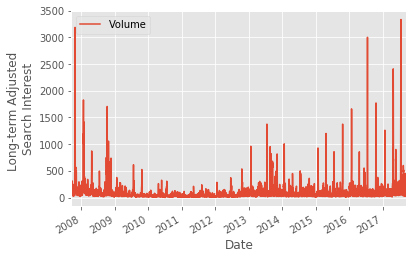

In [26]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

MSFT_csv_path_mac = '/Users/drew/Dropbox/Coding/Python/Sirajology/20170908_Stock_market_prediction/MSFT.csv'
MSFT_csv_path_pc = r'C:\Users\DMacKellar\Dropbox\Coding\Python\Sirajology\20170908_Stock_market_prediction\MSFT.csv'

# on Mac:
# gt_msft = pd.DataFrame.from_csv(MSFT_csv_path_mac)
# on PC:
gt_msft = pd.DataFrame.from_csv(MSFT_csv_path_pc)

print(gt_msft.shape)
gt_msft.head()
gt_msft.tail()

gt_msft.plot()
plt.ylabel('Long-term Adjusted \nSearch Interest')
plt.show()

Wow.  If that script ran correctly, then there is considerable variability in search interest for MSFT in this context.  I'll try comparing it to the web-based csv's for long-term and recent, brief results.

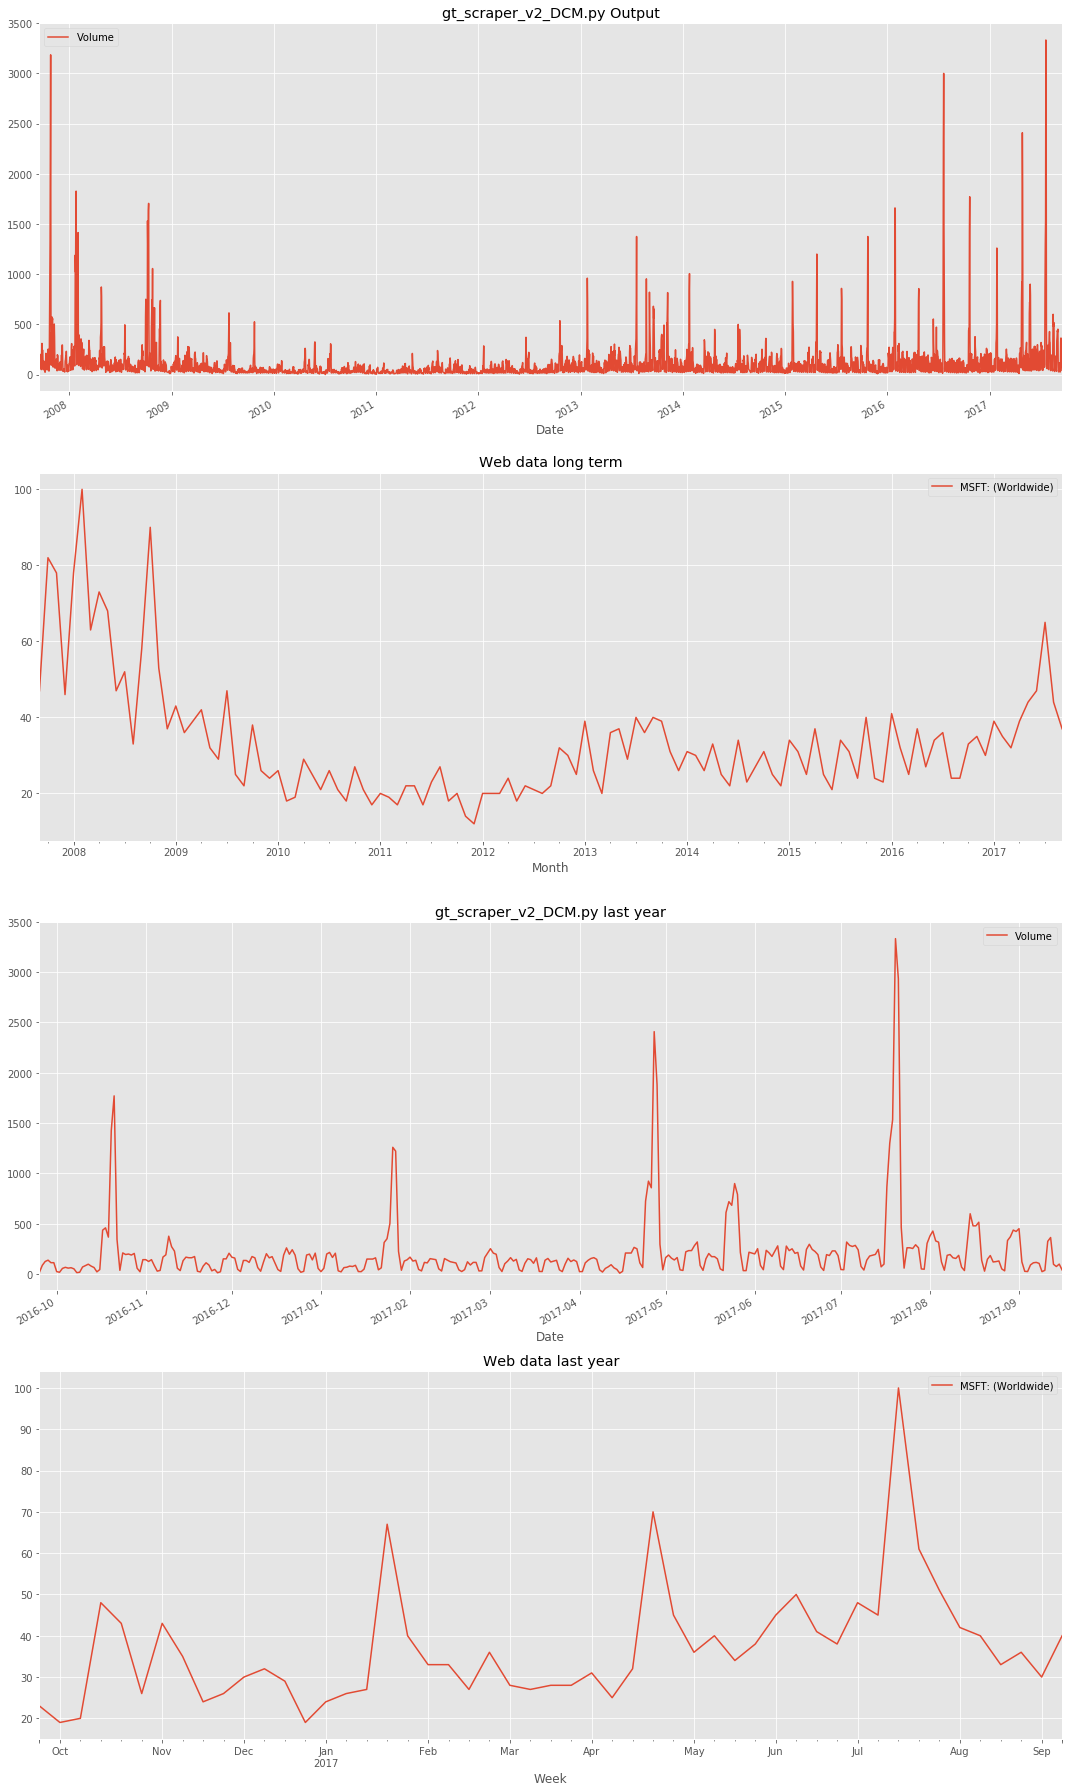

In [27]:
# on Mac:
# MSFT_csv_dir = os.path.dirname(MSFT_csv_path_mac)
# on PC:
MSFT_csv_dir = os.path.dirname(MSFT_csv_path_pc)

msft10y_path = os.path.join(MSFT_csv_dir, 'msft_10yrs.csv')
msftnow_path = os.path.join(MSFT_csv_dir, 'msft_recent.csv')

msft_10 = pd.DataFrame.from_csv(msft10y_path, header=1)
msftnow = pd.DataFrame.from_csv(msftnow_path, header=1)

plt.close('all')

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 25))

# ax[0] = gt_msft.plot(ax=ax[0])
gt_msft.plot(ax=ax[0])
ax[0].set_title('gt_scraper_v2_DCM.py Output')
msft_10.plot(ax=ax[1])
ax[1].set_title('Web data long term')
gt_msft.loc['2016-09-25':].plot(ax=ax[2])
ax[2].set_title('gt_scraper_v2_DCM.py last year')
msftnow.plot(ax=ax[3])
ax[3].set_title('Web data last year')
plt.tight_layout()

plt.show()

In [28]:
# Output GT data
# with open()
print(MSFT_csv_dir)

C:\Users\DMacKellar\Dropbox\Coding\Python\Sirajology\20170908_Stock_market_prediction


Hmm.  Well, for now, I'm having trouble with extra plots being shown (note: subsequently fixed; my error was calling '`# ax[0] = gt_msft.plot()`' instead of '`gt_msft.plot(ax=ax[0])`'), but I'd say that the fine-tuned data do show the same placement of major peaks as the web output.  Applying a smoothing function to the daily data would allow a more direct comparison.  It is worrisome that the 1-year daily data shows such regular periodicity; I guess the script isn't really able to suppress that further when you're fundamentally multiplying all days within each week by some set scaling factor, but you'd hope that the ups and downs each week would be less strong.

I wonder if I could at least get a summary out of the frequencies in these data using `scipy.signal`; maybe the [spectrogram method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html#scipy.signal.spectrogram)?  Maybe some other method would be more appropriate.  [This guide](https://www.safaribooksonline.com/library/view/elegant-scipy/9781491922927/ch04.html) looks like a reasonable intro.

In [29]:
from scipy.signal import spectrogram

spectrogram(gt_msft.loc['2016-09-25':].values.flatten())
# gt_msft.loc['2016-09-25':].values.flatten()

(array([ 0.        ,  0.00390625,  0.0078125 ,  0.01171875,  0.015625  ,
         0.01953125,  0.0234375 ,  0.02734375,  0.03125   ,  0.03515625,
         0.0390625 ,  0.04296875,  0.046875  ,  0.05078125,  0.0546875 ,
         0.05859375,  0.0625    ,  0.06640625,  0.0703125 ,  0.07421875,
         0.078125  ,  0.08203125,  0.0859375 ,  0.08984375,  0.09375   ,
         0.09765625,  0.1015625 ,  0.10546875,  0.109375  ,  0.11328125,
         0.1171875 ,  0.12109375,  0.125     ,  0.12890625,  0.1328125 ,
         0.13671875,  0.140625  ,  0.14453125,  0.1484375 ,  0.15234375,
         0.15625   ,  0.16015625,  0.1640625 ,  0.16796875,  0.171875  ,
         0.17578125,  0.1796875 ,  0.18359375,  0.1875    ,  0.19140625,
         0.1953125 ,  0.19921875,  0.203125  ,  0.20703125,  0.2109375 ,
         0.21484375,  0.21875   ,  0.22265625,  0.2265625 ,  0.23046875,
         0.234375  ,  0.23828125,  0.2421875 ,  0.24609375,  0.25      ,
         0.25390625,  0.2578125 ,  0.26171875,  0.2

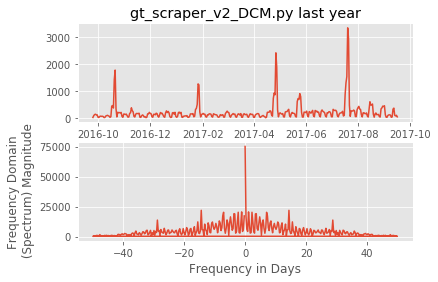

In [30]:
from scipy import fftpack
import numpy as np

x1 = gt_msft.loc['2016-09-25':]
x2 = x1.values.flatten()
X = fftpack.fft(x2)
f_s = 100   # sampling freq; fine/coarse measurement doesn't change pattern
freqs = fftpack.fftfreq(len(x2)) * f_s

plt.close('all')

fig, ax = plt.subplots(nrows=2, ncols=1)

ax[0].plot(x1.index, x1.values)
ax[0].set_title('gt_scraper_v2_DCM.py last year')
ax[1].plot(freqs, np.abs(X))
ax[1].set_xlabel('Frequency in Days')
ax[1].set_ylabel('Frequency Domain\n (Spectrum) Magnitude')
plt.show()

Ok, I'll admit that, at present, I'm not sure how to try to filter the data to remove fluctuations with a period of one week.  Instead, I'll just try measuring correlation again, to see whether increases in Google Trends activity has anything to do with changes in price.

In [31]:
msft_trends_prices = microsoft_stock.join(gt_msft, how='outer')
msft_trends_prices.head()
msft_trends_prices.corr(min_periods=100).iloc[0].sort_values(ascending=False)

MSFT      1.000000
Volume    0.239072
Name: MSFT, dtype: float64

Wow.  That's a really weak correlation.  It may be that looking at the derivative of both data sets would yield a better correlation, but there's a very weak positive correlation between trends and price.  Of course, you could argue that increased search interest in the stock price would correlate with more buying **and** selling; I'm not sure how to code to check that comparison right now.

Another point is that there's plenty of room to optimize the search term for the best correlation with price.  One idea would be to take the output of '`pytrend.related_queries()`', take various timeframes from that tool, output correlations with stock price, then go back and take **THAT** search term through the `gt_scraper` script.

Also see [this discussion](https://www.quantopian.com/posts/google-search-terms-predict-market-movements) on Quantopian.

## Google Correlate

Huh.  I don't know how I missed this before, but Siraj's video references an academic paper the uses something called [Google correlate](https://www.google.com/trends/correlate/#) in predicting stock prices.  That tool is apparently an extension of the well-publicized Google flu trends approach; [it works](https://www.google.com/trends/correlate/comic?p=5) by taking input time series data and finding the search terms whose usage best correlates with those data.  So I'll try outputting the MSFT stock price time series as a csv and upload it.

One wrinkle: [apparently](https://www.google.com/trends/correlate/faq) it only accepts time series data with a maximal resolution of weekly dates.  I was just going to drop all non-Monday dates, but when searching for a quick solution I came across [this post](https://stackoverflow.com/questions/34597926/converting-daily-stock-data-to-weekly-based-via-pandas-in-python) that made me think that some other approach might be more suitable.  For instance, the stock's Volume might be a good metric of activity for a whole week.  But that might be harder to square with the notion that the output should be a recommendation of when to buy or sell the stock, no t just when it will be most volatile.  I suppose I could try both approaches pretty quickly...

In [32]:
from googlefinance.client import get_prices_data, get_prices_time_data
# import importlib
# importlib.reload(googlefinance)

# Usage from (https://pypi.python.org/pypi/googlefinance.client/1.3.0)

params = [
    # Microsoft stock
    {
        'q': "MSFT",
        'i': '604800',
        'x': "NASDAQ",
        'p': '10Y'
    }
]

period = '10Y'
interval = '604800'

# msft_week_price = get_price_data(params)
# msft_week_price = get_prices_data(params, period)
msft_week_price = get_prices_time_data(params, period, interval)
# msft_week_close = get_closing_data(params, period)

I tried getting the volume data first by running the `googlefinance.client` function `get_price_data`, which rolls the '`period`' arg into the '`params`' dict, but that returned an error relating to the '`requests.models`' script, line 97, which is '`for k, vs in to_key_val_list(data):`'.  The ValueError said 'too many values to unpack (expected 2)'.  That particular function is imported from another file in the `requests` package, but basically it says it checks whether the data passed to it is a dict, and, if so, returns a list of `(key, value)` tuples.  I played around with debugging for a bit in PyCharm, but expected that the issue was less likely with `requests` than with the less-thoroughly developed `googlefinance` module.

Rather than troubleshoot the `googlefinance` script too heavily, I noticed that the '`get_closing_data()`' function still worked, and that one takes the period as a separate arg, not requiring it in the input '`params`' dict.  I also noticed that the '`googlefinance.client`' script similarly held multiple independent versions of the '`get_price_data`' function, namely one called '`get_prices_data`' that also takes '`period`' as a separate arg.  I tried loading and using that one, but got a totally different error, still with requests, that complained about a security certificate.

At this point I still thought that the error probably lay with the `googlefinance` module, but googling the error led to [a forum](https://github.com/requests/requests/issues/4171) saying that this really is a common problem with `requests` and Anaconda.  I figured that the `googlefinance` module might be obscure enough that anyone else discussing this error might indicate a real problem with `requests`; not a large enough user base of the former module to get extensive documentation of every issue with it, as I found when I tried googling the original error about the `to_key_val_list`.

A lot of these errors get addressed in code updates; even though the forum about the requests error was only a couple of months old, I tried '`pip install --upgrade requests`' (to no improvement).  Other users said they got around the issue by reinstalling Anaconda.  I didn't want to do that, so I tried '`conda install requests`', and that allowed my cell code to run with the '`get_prices_data`' function in PyCharm's debugger.  I didn't know if that meant it would actually output usable data in Jupyter, but I reloaded the notebook and it did!  

There's still the caveat that the `googlefinance` script ignores whatever interval arg you pass in the '`params`' dict, and outputs daily data instead.  I was gonna parse that in pandas to get back to weekly data, but decided to look at the `googlefinance` script one more time.  There's an alternate variant of the '`get_price_data`' and '`get_prices_data`': '`get_prices_time_data`'.  If I load that and feed the interval to the function instead of via the dict, it does actually output weekly data.

So I wrote this all up instead of just moving on to point out a couple small lessons about debugging:

- Google first, as always; try copy/pasting code from stack overflow
- If stack overflow code doesn't work, resort to actually **reading** all the damn comments about the problem, and adapting them to your particular environment in as few steps as possible.
- If that doesn't work, load pycharm, debug, and see if the variables make sense up to the point the script hangs.
- If a script is really screwing up, blame the least-professionally made module in the list (usually the last one; the one you're trying to run, not the modules on which it depends) first, and assume the more common packages are not the problem.
- This last point above doesn't always hold, however: `requests` itself has issues with the Anaconda distro, and that's a pretty standard library.
- Don't bother understanding and fixing somebody's buggy script if there's some alternative, perhaps equally hastily-written script available!
    - Or, in this case, if the author included multiple variants of the same function within their script.  One may work while another does not.
- If you're hitting multiple different errors within a script when you try different things, it's a good bet they're related to the same fundamental bugginess, **BUT NOT ALWAYS!**
    - In this case, `googlefinance` and `requests` really did have independent issues going on, which I only found out by trying the `get_price_data` and `get_prices_data` functions separately.
    
Anyways, the point is now I can get the stock volume and closing price data in weekly format and try them with Google Correlate.  Note that the `googlefinance` dataframe output has indices with a timestamp, and apparently the Google Correlate tool doesn't want those, so first I'll have to convert them.  It took me WAY too long to figure out the format for that command, though.

In [33]:
msft_week_price.head()

,MSFT_Open,MSFT_High,MSFT_Low,MSFT_Close,MSFT_Volume
2007-11-01 13:00:00,36.53,37.49,36.36,37.06,152078802
2007-11-08 12:00:00,37.22,37.50,36.42,37.06,96399008
2007-11-05 13:00:00,36.76,37.10,36.63,36.73,75485352
2007-11-12 13:00:00,36.59,36.66,35.87,36.41,100966620
2007-11-19 13:00:00,36.04,36.16,35.45,35.52,74897710


In [34]:
msft_week_price.index = msft_week_price.index.date

msft_week_volume = msft_week_price['MSFT_Volume']
msft_week_close = msft_week_price['MSFT_Close']


msft_csv_path_pc = r'C:\Users\DMacKellar\Dropbox\Coding\\
Python\Sirajology\20170908_Stock_market_prediction\Data'
msft_csv_path_mac = '/Users/drew/Dropbox/Coding/Python/\
Sirajology/20170908_Stock_market_prediction/Data'

# on PC:
msft_csv = os.path.join(msft_csv_path_pc, 'msft_week.csv')
msft_week_volume.to_csv(os.path.join(msft_csv_path_pc, 
                                     'msft_week_volume.csv'))
msft_week_close.to_csv(os.path.join(msft_csv_path_pc, 
                                     'msft_week_close.csv'))

# on Mac:
# msft_csv = os.path.join(msft_csv_path_mac, 'msft_week.csv')
# msft_week_volume.to_csv(os.path.join(msft_csv_path_mac, 
#                                      'msft_week_volume.csv'))
# msft_week_close.to_csv(os.path.join(msft_csv_path_mac, 
#                                      'msft_week_close.csv'))

Well.  That's a little underwhelming.  The weekly close data returned some of the following as the top hits:

In [35]:
weekly1 = os.path.join(msft_csv_path_pc, 'correlate-msft_wk_close.csv')

weekly1_df = pd.DataFrame.from_csv(weekly1, header=10)
weekly1_df.head()

,msft_wk_close,lyst,chop saw,rove concepts,eating gif,urban body jewelry,deactivate instagram,enlightened equipment,aussiedoodle,minutes in hours,...,ford f1 50,vsco presets,a03,to oz,what does jt,444 angel,flush mount light,chevy silverado 5.3,part picker,mouth gif
Date,,,,,,,,,,,,,,,,,,,,,
2004-01-04,NaN,-0.852,-0.626,-0.634,-0.731,-0.574,-0.658,-0.609,-1.103,-1.098,...,-0.71,-0.652,0.306,-1.099,-0.679,-0.642,-0.189,-0.857,-0.6,-0.668
2004-01-11,NaN,-0.852,0.021,-0.634,-0.731,-0.574,-0.658,-0.609,-1.103,-1.098,...,-0.71,-0.652,0.174,-1.080,-0.679,-0.642,-1.482,-0.857,-0.6,-0.668
2004-01-18,NaN,-0.852,-0.404,-0.634,-0.731,-0.574,-0.658,-0.609,-1.103,-1.098,...,-0.71,-0.652,0.626,-1.059,-0.679,-0.642,-0.736,-0.857,-0.6,-0.668
2004-01-25,NaN,-0.558,-0.199,-0.634,-0.731,-0.574,-0.658,-0.609,-1.103,-0.654,...,-0.71,-0.652,-0.106,-1.020,-0.679,-0.642,-0.757,-0.857,-0.6,-0.668
2004-02-01,NaN,-0.852,-0.850,-0.634,-0.731,-0.574,-0.658,-0.609,-1.103,-1.098,...,-0.71,-0.652,0.190,-1.068,-0.679,-0.642,-1.482,-0.857,-0.6,-0.668


In [36]:
weekly1_df.describe()

,msft_wk_close,lyst,chop saw,rove concepts,eating gif,urban body jewelry,deactivate instagram,enlightened equipment,aussiedoodle,minutes in hours,...,ford f1 50,vsco presets,a03,to oz,what does jt,444 angel,flush mount light,chevy silverado 5.3,part picker,mouth gif
count,490.000000,689.000000,689.000000,689.000000,689.000000,689.000000,689.000000,689.00000,689.000000,689.000000,...,689.000000,689.000000,689.000000,689.000000,689.000000,689.000000,689.000000,689.000000,689.000000,689.000000
mean,-0.000010,-0.000012,-0.000003,-0.000075,-0.000073,0.000115,-0.000186,-0.00012,-0.000035,-0.000009,...,0.000033,-0.000087,0.000009,0.000004,0.000017,0.000152,-0.000028,0.000045,0.000009,-0.000160
std,1.000005,1.000018,0.999995,1.000043,1.000026,0.999939,1.000103,1.00007,1.000042,1.000010,...,0.999978,1.000063,0.999990,1.000003,0.999967,0.999899,1.000038,0.999959,0.999992,1.000108
min,-2.025000,-0.852000,-1.219000,-0.634000,-0.731000,-0.574000,-0.658000,-0.60900,-1.103000,-1.098000,...,-0.710000,-0.652000,-1.347000,-1.128000,-0.679000,-0.642000,-1.482000,-0.857000,-0.600000,-0.668000
25%,-0.683250,-0.625000,-0.726000,-0.634000,-0.731000,-0.574000,-0.658000,-0.60900,-0.773000,-0.667000,...,-0.710000,-0.652000,-0.753000,-0.682000,-0.679000,-0.642000,-0.614000,-0.705000,-0.600000,-0.668000
50%,-0.321000,-0.527000,-0.370000,-0.634000,-0.605000,-0.574000,-0.658000,-0.60900,-0.343000,-0.472000,...,-0.598000,-0.652000,-0.526000,-0.458000,-0.504000,-0.642000,-0.354000,-0.473000,-0.600000,-0.569000
75%,0.903000,0.484000,0.442000,0.642000,0.594000,0.380000,0.629000,0.35300,0.653000,0.569000,...,0.510000,0.596000,0.538000,0.389000,0.280000,0.382000,0.463000,0.379000,0.426000,0.463000
max,4.749000,3.809000,3.918000,5.148000,4.164000,5.158000,3.302000,4.21900,3.746000,3.761000,...,3.156000,5.107000,2.865000,3.253000,3.217000,3.932000,3.540000,3.050000,4.306000,2.949000


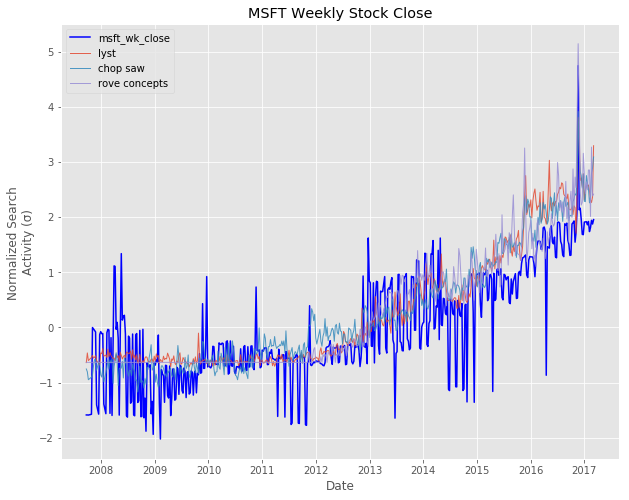

In [37]:
'2007-09-23' in weekly1_df.index
weekly1_df.dropna(subset=['msft_wk_close'], inplace=True)

fig = plt.figure(figsize=(10, 8))

plt.plot(weekly1_df.iloc[:, 0], 'b')
for x in weekly1_df.columns[1:4]:
    plt.plot(weekly1_df[x], label=x, alpha=0.85, linewidth=1)
plt.title('MSFT Weekly Stock Close')
plt.xlabel('Date')
plt.ylabel(u'Normalized Search \nActivity (\u03C3)', fontsize=12)
plt.legend()
plt.show()

"Rove concepts"?  "Chop saw"?

And the weekly volume data didn't even return any results.

I guess I'll have to troubleshoot the options more if Google Correlate is gonna give me anything.  The [Auburn dissertation](https://etd.auburn.edu/bitstream/handle/10415/5652/Application%20of%20machine%20learning%20techniques%20for%20stock%20market%20prediction.pdf?sequence=2) Siraj cites in the video might have some tips on methodology.

...Or maybe not.  The author references 'Google Trends' but not 'Google Correlate' specifically.  The [white paper](https://www.google.com/trends/correlate/whitepaper.pdf) for the tool may offer a bit more, instead.

Hmm, that doesn't seem too informative either.  I guess this may simply be state of the art right now.  The volume data might benefit from rescaling; normalizing or otherwise reducing the variation between the datapoints.

Another thing noted in the tutorial for the tool is that it only returns positive correlations; to recover negative ones it suggests multiplying all of your input datapoints by -1 before submitting.  The raw values returned in the csv output by Google Correlate is just the change relative to the last timepoint, basically the derivative of each trend line.

So whether or not a term is returned is based on having a positive correlation overall between the derivative of the input timeseries data and that of the search term, which means having as close a correlation of the sign and the magnitude of each search term; so when your data are going up, you want a term that's also going up.  But another point is that the '`describe()`' call on the df above shows that each column is automatically transformed into a standard normal distribution by the tool; I'm uncertain whether similarly modifying the input raw values would therefore have much effect.

In [38]:
# Saving files with inverted stock data
# To try finding searches inversely correlated with price

msft_week_volume = msft_week_price['MSFT_Volume'].apply(lambda x: x * -1)
msft_week_close = msft_week_price['MSFT_Close'].apply(lambda x: x * -1)


msft_csv_path_pc = r'C:\Users\DMacKellar\Dropbox\Coding\\
Python\Sirajology\20170908_Stock_market_prediction\Data'

msft_csv = os.path.join(msft_csv_path_pc, 'msft_week.csv')

msft_week_volume.to_csv(os.path.join(msft_csv_path_pc, 
                                     'msft_week_volume_inv.csv'))
msft_week_close.to_csv(os.path.join(msft_csv_path_pc, 
                                     'msft_week_close_inv.csv'))

Again: only found results for the (inverted) closing price, none for the (inverted) volume:

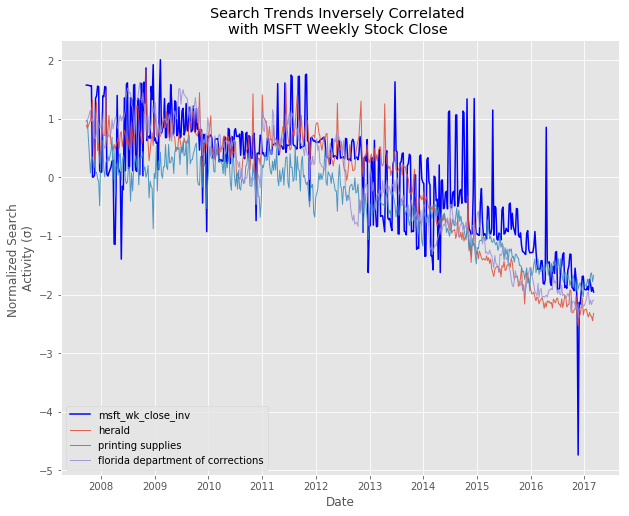

In [39]:
weekly1_inv = os.path.join(msft_csv_path_pc, 
                           'correlate-msft_wk_close_inv.csv')

weekly1_inv_df = pd.DataFrame.from_csv(weekly1_inv, header=10)

weekly1_inv_df.dropna(subset=['msft_wk_close_inv'], inplace=True)

fig = plt.figure(figsize=(10, 8))

plt.plot(weekly1_inv_df.iloc[:, 0], 'b')
for x in weekly1_inv_df.columns[1:4]:
    plt.plot(weekly1_inv_df[x], label=x, alpha=0.85, linewidth=1)
plt.title('Search Trends Inversely Correlated \
\nwith MSFT Weekly Stock Close ')
plt.xlabel('Date')
plt.ylabel(u'Normalized Search \nActivity (\u03C3)', fontsize=12)
plt.legend()
plt.show()

Ok, I'll keep Google Correlate in mind as a potential future strategy, but for MSFT, as-is right now, I'd say it's not useful.  Instead, I'll turn my attention to some of the approaches that other people employed in their responses to Siraj's challenge.  I missed the deadline for sending in my own response, but the upside of that is that there is a larger well of inspiration on which to draw.

As noted in the [9/15/17 video on GPU programming](https://www.youtube.com/watch?v=1cHx1baKqq0), the winner of the weekly challenge was alberduris, whose [code](https://github.com/alberduris/SirajsCodingChallenges/tree/master/Stock%20Market%20Prediction)  instantiated multiple neural networks.  The runner-up was hutauf, whose [code](https://github.com/hutauf/Stock_Market_Prediction) involved converting price data into an audio wave.

What's interesting about alberduris' approach is that he sticks to measures derived from the stock's own price data.  Specifically, he measures 'trend', 'momentum', and volume/'volatility'.  As far as I can tell, these are all derived from the stock he's looking at, not an index measure.  He does a pretty good job [stating briefly](https://github.com/alberduris/SirajsCodingChallenges/blob/master/Stock%20Market%20Prediction/Crypto/PrepareData%20-%20Technical%20Indicators.ipynb) what these measures are, and pointing to some additional resources for further explication.

Modeling-wise, he runs them through a 'deep regressor' and a recurring neural net.  The deep regressor trends the right way, but high; needs a correcting factor to compensate.  The recurring neural network (RNN) looks overfit; a bit too good.

Anyways, he applies the RNN first to the Euro (vs. USD; daily data from 8/13/2007 to present), then to BitCoin (vs. USD; daily values from 2/2/2012 up to the present) via Tensorflow, with 100 epochs of training, using a network with 12 neurons in a single hidden layer.  

---

## Technical Indicators

The following are all various [extended measures of stock performance](https://en.wikipedia.org/wiki/Technical_indicator) based on price data alone; they don't draw upon outside sources of knowledge such as media attention, search results, or broad stock indices.  All are essentially efforts to determine a stable, longer-term value of a stock, and identify when the market has temporarily over- or under-valued the stock; if you can identify such a trend and get out in front of it, you stand to profit.

They come in several main kinds; the ones used in the example notebook are:
- [Trends](https://en.wikipedia.org/wiki/Market_trend) - in this case, apparently in an individual stock's price, although the article referenced speaks of the performance of the entire market as bullish or bearish; determining whether things are going up or down over various timeframes.  `alberduris` uses the moving average convergence/divergence.
- [Momentum](https://en.wikipedia.org/wiki/Momentum_(finance)) - when a stock is going up or down for a long enough time, a basic observation (& accordingly a common assumption) is that it is more likely to continue in the same direction before reversing direction; measuring momentum is the attempt to get a historical perspective on how long such swings usually last for the stock, and therefore how long you might expect the current trend to continue.  `alberduris` uses the [stochastic oscillator](https://en.wikipedia.org/wiki/Stochastic_oscillator) here.
- [Volatility](https://en.wikipedia.org/wiki/Volatility_(finance)) - regardless of trends and momentum, some stocks tend to be held for a long time without much trading occurring; others change price and get bought and sold more frequently.


### MACD

All right, what the heck; I can try grabbing these same indicators for MicroSoft stock and seeing if they correlate well with price.  First, the [moving average convergence/divergence oscillator](http://www.investopedia.com/terms/m/macd.asp) (MACD).  This is an attempt to summarize trends in a stock price by using [moving average data](http://www.investopedia.com/terms/e/ema.asp).  A simple moving average is just the average price over some window (20 days is mentioned in the video), whereas an exponential moving average (EMA) uses the same input data but weights them more heavily on the most recent datapoints, favoring data points more temporally proximal to the present.  

Basically, to get the MACD it sounds like you take this EMA for three different window sizes (9, 12 and 26 days are mentioned in the video), subtract the the largest average from that of the middle-sized window, and plot the resulting line alongside the smallest-window EMA (which is called the 'signal line'; usually it's recommended to buy stock when the MACD crosses above the signal line, and to sell when it falls below it).  To clarify, apparently the difference between the two largest window EMAs is called the MACD itself, but it's usually plotted alongside a signal line, so you don't generally see reference to the MACD in the absence of a third EMA.  
So what would this accomplish?  I guess that we're mostly looking at short-term trends here, so we're more interested in capitalizing upon movements of the market for a stock that we only intend to hold for a few days or weeks, rather than a long-term value investment.  The MACD is comparing recent shorter-term price (12 day window) to a slightly longer one (26 day window).  This is essentially meant to show what the stock has been doing in the past couple of weeks.  The 'signal line' of an even shorter window is meant to show what the stock has been doing even more recently, so that you can see how the market is trending on that stock.  The longer-term averages represent kind of a more 'core value' measure of the stock, whereas the shorter-term ones indicate the human element of getting excited about a stock recently.  You're betting with/against other people.  

When the more recent measure crosses above the past one, rather than assuming that the stock is immediately overvalued and should be sold, you assume that people are excited about the stock and will tend to buy more for a time.  The timing and size of these relative measures seems to be key; you wouldn't generally bet that a trend will last more than a few days unless something significant has changed in the company's position, and if it climbs too quickly it might represent a rampant overvaluation.  But you might still want to wait to see a large enough and long enough uptrend before buying; minor fluctuations can still occur and amount to nothing.  Anyways, that's my very facile reading of this topic; you're betting that, if a stock goes up or down enough relative to prices from a couple of weeks ago, such a trend will continue for a bit.

alberduris calculates his own MACD using a custom function relying upon the built-in pandas function `pd.ewm()` to first calculate the exponential moving average of two time windows.

...Hmm, I was having trouble figuring out why I wasn't getting a lower plot that looked anything like the histogram on MACD plots I was seeing online, but then I saw [this Wikipedia article](https://en.wikipedia.org/wiki/MACD), which made clear in the topmost graph that the signal should not be the 9-day EMA of the raw stock price data, but the 9-day EMA **of the MACD itself**.  (This distinction is actually also apparent in alberduris' code; I just overlooked the distinction when repurposing his code.)  Therefore, it's just acting as yet another, shorter-term window on the data, but on the calculated indicator itself, not on the closing price.

In [40]:
# alberduris' functions to calculate Technical Indicators
# from price data

def MACD(df,period1,period2,periodSignal):
    EMA1 = pd.DataFrame.ewm(df,span=period1).mean()
    EMA2 = pd.DataFrame.ewm(df,span=period2).mean()
    MACD = EMA1-EMA2
    
    Signal = pd.DataFrame.ewm(MACD,periodSignal).mean()
    
    Histogram = MACD-Signal
    
    return Histogram

def stochastics_oscillator(df,period):
    l, h = pd.DataFrame.rolling(df, period).min(), pd.DataFrame.rolling(df, period).max()
    k = 100 * (df - l) / (h - l)
    return k

def ATR(df,period):
    '''
    Method A: Current High less the current Low
    '''
    df['H-L'] = abs(df['High']-df['Low'])
    df['H-PC'] = abs(df['High']-df['Close'].shift(1))
    df['L-PC'] = abs(df['Low']-df['Close'].shift(1))
    TR = df[['H-L','H-PC','L-PC']].max(axis=1)
    return TR.to_frame()

In [41]:
%who_ls

microsoft_stock['ewm_9'] = pd.DataFrame.ewm(microsoft_stock['MSFT'], span=9).mean()
microsoft_stock['ewm_12'] = pd.DataFrame.ewm(microsoft_stock['MSFT'], span=12).mean()
microsoft_stock['ewm_26'] = pd.DataFrame.ewm(microsoft_stock['MSFT'], span=26).mean()

microsoft_stock['MACD'] = microsoft_stock['ewm_12'] - microsoft_stock['ewm_26']
microsoft_stock['signal'] = pd.DataFrame.ewm(microsoft_stock['MACD'], span=9).mean()
microsoft_stock.head()

,MSFT,ewm_9,ewm_12,ewm_26,MACD,signal
2007-11-01,37.06,37.060000,37.060000,37.060000,0.000000,0.000000
2007-11-02,37.06,37.060000,37.060000,37.060000,0.000000,0.000000
2007-11-05,36.73,36.924754,36.931201,36.941434,-0.010233,-0.004194
2007-11-06,36.41,36.750379,36.766678,36.792868,-0.026190,-0.011645
2007-11-07,35.52,36.384369,36.427960,36.497685,-0.069725,-0.028923


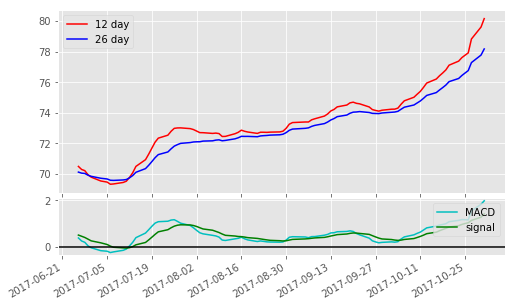

In [42]:
plt.close('all')

fig = plt.figure(figsize=(8, 5))

ax2 = plt.subplot2grid(shape=(4, 3), loc=(3, 0), 
                       rowspan=1, colspan=3)
ax1 = plt.subplot2grid(shape=(4, 3), loc=(0, 0), 
                       rowspan=3, colspan=3, sharex=ax2)
fig.subplots_adjust(hspace=0)
ax1.set_xticklabels(ax1.get_xticklabels(), visible=False)
ax1.grid(True)
# ax1.set_xticks([])
# ax1.set_yticks(ax1.get_yticks()[1:])

per = -90
macd_dates = microsoft_stock.index[per:]
signal = microsoft_stock['signal'][per:]
ewm12 = microsoft_stock['ewm_12'][per:]
ewm26 = microsoft_stock['ewm_26'][per:]
macd = microsoft_stock['MACD'][per:]

ax1.plot(macd_dates, ewm12,
         label='12 day', color='red')
ax1.plot(macd_dates, ewm26,
         label='26 day', color='blue')
ax1.legend()

# ax2.hist(macd - signal)
ax2.plot(macd_dates, macd, color='c')
ax2.plot(macd_dates, signal, '-', color='g')
ax2.axhline(0, color='black')
ax2.legend(loc=1)
fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')
plt.subplots_adjust(hspace=0.1)

plt.show()

Ok, I daresay that looks close enough to [other representations](http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:moving_average_convergence_divergence_macd) of the MACD plot to confirm that it's looking about right.  Next, to employ some of the approach of `alberduris`, I'll try copying his measure of momentum in the stock.

---

### Stochastic Oscillator

Measurements of momentum sound like an extension of that of trends from the previous section; namely, that you're trying to predict how much longer the current trend will continue before reversing.

The [stochastic oscillator](http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:stochastic_oscillator_fast_slow_and_full) takes as arguments a period ending in the present to look back over, and finds the lowest and highest prices in that period.  Then it returns the difference between the current price and the lowest price, as a percentage of the greatest difference in stock prices over the whole look-back period.  This statistic is called '_%K_'.  Then, sometimes (apparently, since `alberduris` doesn't use this), you can apply another factor to this percentage to return a 3-day moving average of *%K* (the last 3 values of %K).  This latter statistic is called '*%D*'.  Apparently, however, these describe the "fast stochastic oscillator"; there's a "slow" variant that involves smoothing the *%K* measure with a 3-period simple moving average before returning it or calculating *%D*.

In other words, it tells you how the current price compares to the entire period you're looking back over.  If the price is at 99% of the highest price it's been at for the last month, then you might be justified in thinking that it's due for a downturn (unless the trend analysis indicates that it's on a long-term uptrend).  Another [important point](http://www.investopedia.com/articles/active-trading/021915/pick-right-settings-your-stochastic-oscillator.asp) is that a shorter lookback period will provide choppier output with more suggested opportunities to sell overbought or buy oversold stocks, whereas longer periods will be smoother, and suggest fewer opportunities to buy and sell.  The period you choose will depend on whether you're tending more towards day-trading or holding value stocks, but a common choice appears to be about 14 days.

I'll try calculating the fast stochastic oscillator below, in accordance iwth the approach applied by `alberduris`.  Getting the stats related to the lookback period is accomplished via pandas' ['`pd.df.rolling()`' method](https://pythonprogramming.net/rolling-statistics-data-analysis-python-pandas-tutorial/).

In [43]:
def stochastics_oscillator(df, period):
    l, h = pd.DataFrame.rolling(df, period).min(), pd.DataFrame.rolling(df, period).max()
    k = 100 * (df - l) / (h - l)
    return k

In [44]:
microsoft_stock.head()
microsoft_stock['stoch_%K'] = stochastics_oscillator(microsoft_stock['MSFT'], 14)
# pd.DataFrame.rolling(microsoft_stock['MSFT'], 14).min()
microsoft_stock.dropna(inplace=True)
microsoft_stock.head()

,MSFT,ewm_9,ewm_12,ewm_26,MACD,signal,stoch_%K
2007-11-20,34.58,34.331703,34.425484,34.666079,-0.240595,-0.241824,32.608696
2007-11-21,34.23,34.310621,34.392737,34.618906,-0.226169,-0.238579,23.097826
2007-11-23,34.11,34.269335,34.346013,34.565670,-0.219658,-0.234685,21.791045
2007-11-26,32.97,34.003481,34.121181,34.403696,-0.282515,-0.244471,0.000000
2007-11-27,33.06,33.811323,33.949431,34.270941,-0.321510,-0.260162,3.529412


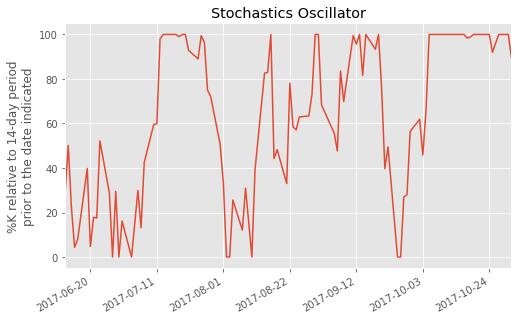

In [45]:
plt.close('all')
fig = plt.figure(figsize=(8, 5))

microsoft_stock['stoch_%K'][-100:].plot()
plt.title('Stochastics Oscillator')
# plt.xlabel('Date')
plt.ylabel('%K relative to 14-day period\nprior to the date indicated')
fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')
plt.show()

I would interpret the area under the curve of the above graph to indicate that the stock was on a general uptrend over the 100-day period shown, since the oscillator spends more time sticking closer to the 100% mark, but I could be misinterpreting this result.

Anyways, let's calculate the final indicator: volatility.

---

### Average True Range

Apparently the ATR may frequently take note of hi and lo prices within individual days, but I'll just be applying it to daily closing prices here.

To [quote](https://en.wikipedia.org/wiki/Average_true_range) directly:

    The true range is the largest of the:

    - Most recent period's high minus the most recent period's low
    - Absolute value of the most recent period's high minus the previous close
    - Absolute value of the most recent period's low minus the previous close
    
    The ATR at the moment of time t is calculated using the following formula:[5] (This is one form of an exponential moving average)

<center>${\displaystyle ATR_{t}={{ATR_{t-1}\times (n-1)+TR_{t}} \over n}}$</center>

    The first ATR value is calculated using the arithmetic mean formula:
    
    
<center>${\displaystyle ATR={1 \over n}\sum _{i=1}^{n}TR_{i}}$</center>

    The idea of ranges is that they show the commitment or enthusiasm of traders. Large or increasing ranges suggest traders prepared to continue to bid up or sell down a stock through the course of the day. Decreasing range suggests waning interest.
    
Again, a period of two weeks seems like an acceptable starting point.

In [46]:
def ATR(df,period):
    '''
    Method A: Current High less the current Low
    '''
    df['H-L'] = abs(df['High']-df['Low'])
    df['H-PC'] = abs(df['High']-df['Close'].shift(1))
    df['L-PC'] = abs(df['Low']-df['Close'].shift(1))
    TR = df[['H-L','H-PC','L-PC']].max(axis=1)
    return TR.to_frame()

The exact code implemented by `albertduris` seems less helpful here, as I don't have columns labeled '`High`', '`Low`', or '`Close`' in my df.  But since those values sound to be kind of integral to calculating this statistic, I suppose I'd better recover them, then append to the df..

In [47]:
from googlefinance.client import get_prices_data

params = [
    # Microsoft stock
    {
        'q': "MSFT",
        'x': "NASDAQ",
    }
]

period = '10Y'

microsoft_price = get_prices_data(params, period)

In [48]:
microsoft_price.head()

,MSFT_Open,MSFT_High,MSFT_Low,MSFT_Close,MSFT_Volume
2007-11-01,36.53,37.49,36.36,37.06,152078802
2007-11-02,37.22,37.50,36.42,37.06,96399008
2007-11-05,36.76,37.10,36.63,36.73,75485352
2007-11-06,36.59,36.66,35.87,36.41,100966620
2007-11-07,36.04,36.16,35.45,35.52,74897710


In [49]:
rename = {}
for col in microsoft_price.columns:
    rename[col] = col.lstrip('MSFT_')
microsoft_price.rename(columns=rename, inplace=True)
microsoft_price.head()

,Open,High,Low,Close,Volume
2007-11-01,36.53,37.49,36.36,37.06,152078802
2007-11-02,37.22,37.50,36.42,37.06,96399008
2007-11-05,36.76,37.10,36.63,36.73,75485352
2007-11-06,36.59,36.66,35.87,36.41,100966620
2007-11-07,36.04,36.16,35.45,35.52,74897710


In [50]:
microsoft_stock['ATR'] = ATR(microsoft_price, 14)
microsoft_stock.head()

,MSFT,ewm_9,ewm_12,ewm_26,MACD,signal,stoch_%K,ATR
2007-11-20,34.58,34.331703,34.425484,34.666079,-0.240595,-0.241824,32.608696,1.01
2007-11-21,34.23,34.310621,34.392737,34.618906,-0.226169,-0.238579,23.097826,0.55
2007-11-23,34.11,34.269335,34.346013,34.565670,-0.219658,-0.234685,21.791045,0.73
2007-11-26,32.97,34.003481,34.121181,34.403696,-0.282515,-0.244471,0.000000,1.44
2007-11-27,33.06,33.811323,33.949431,34.270941,-0.321510,-0.260162,3.529412,0.92


Ok, cool; looks good and ready to feed into a RNN.  I'll save the data to a `csv` file for now.

In [51]:
with open(os.path.join(data_dir_pc, 'msft_techi.csv'), 'w') as f:
    microsoft_stock.to_csv(path_or_buf=f)

# Resuming After Building Tech Indicators

Start here if resuming this notebook after resetting and clearing data.

In [52]:
data_dir_pc = r'C:\Users\DMacKellar\Dropbox\Coding\\
Python\Sirajology\20170908_Stock_market_prediction\Data'
data_dir_mac = '/Users/drew/Dropbox/Coding/Python/\
Sirajology/20170908_Stock_market_prediction/Data/'

# On PC:
data_dir = data_dir_pc

# On Mac:
# data_dir = data_dir_mac

import pandas as pd
import numpy as np
import os, sys
import tensorflow as tf
import matplotlib.pyplot as plt


with open(os.path.join(data_dir, 'msft_techi.csv'), 'r') as f:
    microsoft_stock = pd.read_csv(f)
    microsoft_stock.set_index(microsoft_stock.columns[0],
                                   inplace=True)
    microsoft_stock.index.name = None

    
microsoft_stock.head()

,MSFT,ewm_9,ewm_12,ewm_26,MACD,signal,stoch_%K,ATR
2007-11-20,34.58,34.331703,34.425484,34.666079,-0.240595,-0.241824,32.608696,1.01
2007-11-21,34.23,34.310621,34.392737,34.618906,-0.226169,-0.238579,23.097826,0.55
2007-11-23,34.11,34.269335,34.346013,34.565670,-0.219658,-0.234685,21.791045,0.73
2007-11-26,32.97,34.003481,34.121181,34.403696,-0.282515,-0.244471,0.000000,1.44
2007-11-27,33.06,33.811323,33.949431,34.270941,-0.321510,-0.260162,3.529412,0.92


# Alternate Strategy: Random Stocks

I could grab a couple, or pick and choose, but I really don't know what I'm looking for.  Instead, I think I'll try getting a list of all stocks on a couple exchanges, stratifying by market cap, and randomly grabbing a few examples of each.

According to [this](https://stackoverflow.com/a/25339061) stack overflow response, you can get lists for NYSE and Nasdaq pretty easily.  I put them into the same Data dir as everything else, with the filenames 'nasdaq_list.csv' & 'nyse_list.csv'.

In [53]:
nyse_path = os.path.join(data_dir, 'nyse_list.csv')
nasdaq_path = os.path.join(data_dir, 'nasdaq_list.csv')

nyse_symbols_df = pd.DataFrame.from_csv(nyse_path)
nasdaq_symbols_df = pd.DataFrame.from_csv(nasdaq_path)

nyse_symbols_df.sort_values(by='MarketCap', inplace=True)
nyse_symbols_df = nyse_symbols_df[nyse_symbols_df.MarketCap != 0]
nasdaq_symbols_df.sort_values(by='MarketCap', inplace=True)
nasdaq_symbols_df = nasdaq_symbols_df[nasdaq_symbols_df.MarketCap != 0]

print('NYSE Market Caps:\n{}'.format(
    nyse_symbols_df['MarketCap'].describe()))

print('\n\nNasdaq Market Caps:\n{}'.format(
    nasdaq_symbols_df['MarketCap'].describe()))

nyse_symbols_df.head()

NYSE Market Caps:
count    2.462000e+03
mean     1.138318e+10
std      3.117000e+10
min      3.674642e+06
25%      5.058305e+08
50%      1.925043e+09
75%      7.421845e+09
max      4.526803e+11
Name: MarketCap, dtype: float64


Nasdaq Market Caps:
count    2.944000e+03
mean     3.844873e+09
std      2.996488e+10
min      4.541000e+02
25%      7.091822e+07
50%      3.201012e+08
75%      1.271177e+09
max      8.246287e+11
Name: MarketCap, dtype: float64


,Name,LastSale,MarketCap,ADR TSO,IPOyear,Sector,Industry,Summary Quote,Unnamed: 9
Symbol,,,,,,,,,
WMLP,"Westmoreland Resource Partners, LP",2.86,3.674642e+06,n/a,2015,Energy,Coal Mining,http://www.nasdaq.com/symbol/wmlp,NaN
WAC,Walter Investment Management Corp.,0.4679,1.709799e+07,n/a,n/a,Finance,Finance: Consumer Services,http://www.nasdaq.com/symbol/wac,NaN
SRF,Cushing Energy Income Fund (The),8.2202,2.034490e+07,n/a,2012,n/a,n/a,http://www.nasdaq.com/symbol/srf,NaN
XNY,China Xiniya Fashion Limited,1.48,2.106379e+07,n/a,2010,Consumer Non-Durables,Apparel,http://www.nasdaq.com/symbol/xny,NaN
BIOA,BioAmber Inc.,0.449,2.335418e+07,n/a,2013,Basic Industries,Major Chemicals,http://www.nasdaq.com/symbol/bioa,NaN


In [54]:
import numpy as np

# Grab 3 stocks each from low, mid, & hi market cap


In [55]:
from googlefinance.client import get_closing_data, get_price_data

params = [
    # SPDR Gold Trust
    {
        'q': "GLD",
        'x': "NASD",
    },
    # Crude oil
    {
        'q': "WTI",
        'x': "NYMEX",
    },
    # Real Estate
    {
        'q': "VNQ",
        'x': "NYSEARCA",
    },
    # Hedge Funds
    {
        'q': 'QAI',
        'x': 'NYSEARCA'
    }
]

period = '10Y'
target_stocks = get_closing_data(params, period)

# RNN

I'll similarly follow `alberduris`' code to set up the recurrent neural network, as I still don't have a lot of experience initializing Tensorflow sessions.

Basic first steps: import tf, make a new df with the columns MSFT, MACD, stoch\_%K, and ATR, normalize each predictor independently so that you have compatible  measures to build features out of.  then set the MSFT closing price data forward one day (that is, make each value for it the corresponding value for the index one day earlier.  Perform a stratified train/test split, set MSFT as labels and the rest as features.

Then set hyperparameters for the RNN; if it runs fast enough I can use randomizedsearchcv to try to optimize these, but stick with those used by `alberduris` to start.

In [56]:
# Build new df with relevant predictors, and stock price
# shifted back one day to serve as labels

microsoft_stock2 = microsoft_stock.copy()[['MACD', 'stoch_%K', 'ATR']].join(
    microsoft_stock.copy()['MSFT'].shift(periods=-1))

microsoft_stock2.dropna(inplace=True)
microsoft_stock2.head()

,MACD,stoch_%K,ATR,MSFT
2007-11-20,-0.240595,32.608696,1.01,34.23
2007-11-21,-0.226169,23.097826,0.55,34.11
2007-11-23,-0.219658,21.791045,0.73,32.97
2007-11-26,-0.282515,0.000000,1.44,33.06
2007-11-27,-0.321510,3.529412,0.92,33.70


In [57]:
# Rescale (normalize) each predictor individually

from sklearn.preprocessing import StandardScaler

# Annoying detail; have to instantiate a variable
# as an example of StandardScaler; can't call it directly
scaler = StandardScaler()

microsoft_stock2[microsoft_stock2.columns[:-1]] = scaler.fit_transform(microsoft_stock2[microsoft_stock2.columns[:-1]])

microsoft_stock2.describe()

,MACD,stoch_%K,ATR,MSFT
count,2.503000e+03,2.503000e+03,2.503000e+03,2503.000000
mean,1.059214e-16,5.127518e-16,2.272786e-16,37.344813
std,1.000200e+00,1.000200e+00,1.000200e+00,14.396213
min,-3.022682e+00,-1.563927e+00,-1.222870e+00,15.150000
25%,-6.428133e-01,-9.323721e-01,-5.882949e-01,26.733850
50%,3.504629e-02,1.244271e-01,-2.419395e-01,31.100000
75%,5.919629e-01,9.812879e-01,2.919227e-01,46.605000
max,4.015547e+00,1.231842e+00,1.369989e+01,83.890000


In [58]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    microsoft_stock2[['MACD', 'stoch_%K',  'ATR']], 
    microsoft_stock2['MSFT'], test_size=0.33, random_state=0)

In [59]:
# Set TF Hyperparams

num_epochs = 100

batch_size = 1

total_series_length = X_train.shape[0]

truncated_backprop_length = 3   # The size of the sequence

state_size = 12   # The number of neurons

num_features = 3
num_classes = 1   # [1,0]

num_batches = total_series_length//batch_size//truncated_backprop_length

min_test_size = 100

print('The total series length is: %d' %total_series_length)
print('The current configuration gives us %d batches of %d observations each one looking %d steps in the past' 
      %(num_batches,batch_size,truncated_backprop_length))

The total series length is: 1677
The current configuration gives us 559 batches of 1 observations each one looking 3 steps in the past


In [60]:
import tensorflow as tf

Crap.  I forgot that, because I recently reinstalled Anaconda on my PC, I need to reinstall Tensorflow, too.

When I try to install it, however, I'm getting:

    File "C:\Python\lib\site-packages\pip\index.py", line 731, in __init__
        namespaceHTMLElements=False,
    TypeError: parse() got an unexpected keyword argument 'transport_encoding'
    
I got `conda install tensorflow` to work, but it caused the constant recurring problem that I'm seeing where Jupyter then wouldn't show the `conda` tab.  I followed all of [these directions](https://github.com/jupyter/jupyter/issues/245#issuecomment-287080203), and eventually got it back.  It shows tensorflow as installed now.

In [61]:
batchX_placeholder = tf.placeholder(
    dtype=tf.float32, 
    shape=[None, truncated_backprop_length, num_features], 
    name='data_ph')

batchY_placeholder = tf.placeholder(
    dtype=tf.float32, 
    shape=[None, truncated_backprop_length, num_classes], 
    name='target_ph')

(from `alberduris`' notebook explaining initialization):

**Weights and biases**

Because is a 3 layer net:
1. Input
2. Hidden Recurrent layer
3. Output
We need 2 pairs of W and b

In [62]:
W2 = tf.Variable(
    initial_value=np.random.rand(state_size,num_classes),
    dtype=tf.float32,
    # DCM edit: name for TensorBoard
    name='W2')

b2 = tf.Variable(
    initial_value=np.random.rand(1,num_classes),
    dtype=tf.float32,
    # DCM edit: name for TB
    name='b2')

In [63]:
labels_series = tf.unstack(batchY_placeholder, axis=1)


# Forward pass - Unroll the cell: Input to recurrent

cell = tf.contrib.rnn.BasicRNNCell(num_units=state_size)#, reuse=True)

states_series, current_state = tf.nn.dynamic_rnn(
    cell=cell,
    inputs=batchX_placeholder,
    dtype=tf.float32)

states_series = tf.transpose(states_series,[1,0,2])


# Backward pass - Output

last_state = tf.gather(params=states_series,
                       indices=states_series.get_shape()[0]-1)

last_label = tf.gather(params=labels_series,
                       indices=len(labels_series)-1)

# Weights and Bias out

weight = tf.Variable(tf.truncated_normal([state_size,num_classes]),
                    name='Weight_out')
bias = tf.Variable(tf.constant(0.1,shape=[num_classes]),
                   name='bias_out')

# Prediction, Loss, and Optimizer

prediction = tf.matmul(last_state,weight) + bias

loss = tf.reduce_mean(tf.squared_difference(last_label,prediction))

train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

C:\Python\lib\site-packages\tensorflow\python\ops\gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [64]:
# %%time

# loss_list = []
# test_pred_list = []

# with tf.Session() as sess:
    
#     tf.global_variables_initializer().run()
    
#     for epoch_idx in range(num_epochs):
                
#         print('Epoch %d' %epoch_idx)
        
#         for batch_idx in range(num_batches):
#             start_idx = batch_idx * truncated_backprop_length
#             end_idx = start_idx + truncated_backprop_length * batch_size
        
            
#             batchX = X_train.as_matrix()[start_idx:end_idx,:].reshape(batch_size,truncated_backprop_length,num_features)
#             batchY = y_train.as_matrix()[start_idx:end_idx].reshape(batch_size,truncated_backprop_length,1)
                
#             #print('IDXs',start_idx,end_idx)
#             #print('X',batchX.shape,batchX)
#             #print('Y',batchX.shape,batchY)
            
#             feed = {batchX_placeholder : batchX, batchY_placeholder : batchY}
            
#             #TRAIN!
#             _loss,_train_step,_pred,_last_label,_prediction = sess.run(
#                 fetches=[loss,train_step,prediction,last_label,prediction],
#                 feed_dict = feed
#             )
            
#             loss_list.append(_loss)
            
           
            
#             if(batch_idx % 50 == 0):
#                 print('Step %d - Loss: %.6f' %(batch_idx,_loss))
                
#     #TEST
    
    
#     for test_idx in range(len(x_Test) - truncated_backprop_length):
        
#         testBatchX = X_test[test_idx:test_idx+truncated_backprop_length,:].reshape((1,truncated_backprop_length,num_features))        
#         testBatchY = y_test[test_idx:test_idx+truncated_backprop_length].reshape((1,truncated_backprop_length,1))

        
#         #_current_state = np.zeros((batch_size,state_size))
#         feed = {batchX_placeholder : testBatchX,
#             batchY_placeholder : testBatchY}

#         #Test_pred contains 'window_size' predictions, we want the last one
#         _last_state,_last_label,test_pred = sess.run([last_state,last_label,prediction],feed_dict=feed)
#         test_pred_list.append(test_pred[-1][0]) #The last one

Well, that ran for a couple of days on the Mac (probably most of it was inactive downtime), then stopped after epoch 9999 with:

    NameError: name 'xTest' is not defined

So the output was null.  Still, I can tell from the output that the loss bottomed out around Epoch 1000, so if I repeat it there's no need to go for nearly as long.

I saved the terminal (cell) output of that initial, failed, long run to "C:\Users\DMacKellar\Dropbox\Coding\Python\Sirajology\20170908_Stock_market_prediction\Data\20171005_failed_rnn_output.txt".

The output has a formulaic output: Epoch in the first line, then 12 lines of 'steps' and the corresponding losses.  I should be able to parse and visualize these fairly quickly.

In [65]:
term_out = r'C:\Users\DMacKellar\Dropbox\Coding\Python\\
Sirajology\20170908_Stock_market_prediction\Data\\
20171005_failed_rnn_output.txt'

with open(term_out, 'r') as f:
    term_out_lines = [line.rstrip('\n') for line in f.readlines()]
    
epoch = term_out_lines[0::13]
steps = ['Step %i' % x for x in list(range(0, 551, 50))]
values = pd.DataFrame(index=epoch, columns=steps)
for x in range(0, len(term_out_lines)):
    words = term_out_lines[x].split()
    if x % 13 == 0:
        continue
    elif x % 13 != 0:
        values[' '.join(words[:2])][values.index[x//13]] = float(words[-1])

values.head()

,Step 0,Step 50,Step 100,Step 150,Step 200,Step 250,Step 300,Step 350,Step 400,Step 450,Step 500,Step 550
Epoch 0,2277.97,1476.63,725.889,4824.98,270.771,427.887,93.5238,196.335,1199.14,659.095,1927.11,188.53
Epoch 1,1046.24,486.972,190.166,3134.67,32.5807,150.202,3.1496,47.7284,778.789,366.473,1422.45,59.1627
Epoch 2,687.738,260.265,65.6161,2544.94,0.08571,48.6524,11.5243,3.45362,527.136,204.699,1087.02,9.19704
Epoch 3,465.271,133.661,13.2609,2123.61,15.9018,7.79455,56.0384,4.5789,362.781,109.914,853.725,0.415408
Epoch 4,320.519,63.3982,0.017454,1819.5,53.8888,0.225502,113.817,27.4477,256.819,56.8655,693.733,11.9561


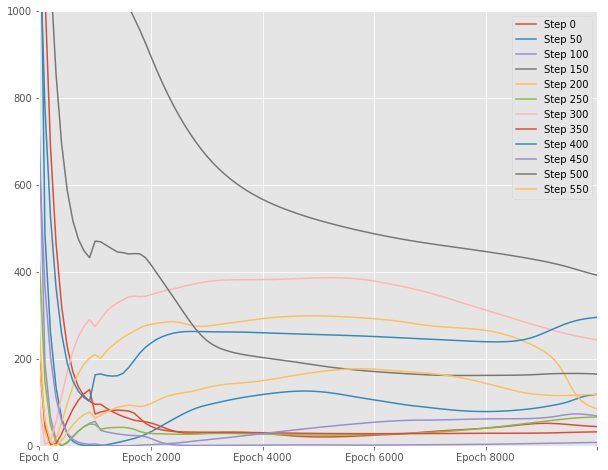

In [66]:
plt.close('all')
values.plot(figsize=(10, 8))
plt.xlim(0, 100)
plt.ylim(0, 1000)
plt.legend(loc=0)
plt.show()

I wanted to visualize these because the losses for each step are pretty different; I'm still not clear exactly what's going on with each step - the code above shows that 'batch_idx' is what's getting passed as the step int.

Anyways, although the loss associated with each step will wander up and down some, it's still generally true that they're leveling off for step 0 by around Epoch 10,000; the greatest gains are to be had before Epoch 4,000.  So I'll try retraining the model with no more than 1,000 epochs.  It would also be good to get tensorboard going here, and save the model so I don't lose the time trained if I hit another snag.  

...Which I did; my code below had a case issue in line 44.  I had '`len(x_test)`' instead of '`len(X_test)`'; that was after training for perhaps ~15 min.  Then I reset and ran again, and got another error; finding out that this time the variable was mis-named '`X_Test`' (capital T, which is wrong).  I really should try saving the model after training instead of letting these dumb errors ruin the output.

The code for setting up tensorboard and saving logging data for a TensorFlow run are summarized in the Dropbox folder for Sirajology, specifically at:

    C:\Users\DMacKellar\Dropbox\Coding\Python\Sirajology\TB01.ipynb
    
One of the crucial first steps is setting up the model topology explicitly:

    # This network is the same as the previous one except with an extra hidden layer + dropout
    def model(X, w_h, w_h2, w_o, p_keep_input, p_keep_hidden):
        # Add layer name scopes for better graph visualization
        with tf.name_scope("layer1"):
            X = tf.nn.dropout(X, p_keep_input)
            h = tf.nn.relu(tf.matmul(X, w_h))
        with tf.name_scope("layer2"):
            h = tf.nn.dropout(h, p_keep_hidden)
            h2 = tf.nn.relu(tf.matmul(h, w_h2))
        with tf.name_scope("layer3"):
            h2 = tf.nn.dropout(h2, p_keep_hidden)
            return tf.matmul(h2, w_o)
            
Then, he creates a couple '`tf.name_scope()`' calls, naming 'accuracy' and 'cost' for referencing later.  Finally, right before training the model, he sets up a graph writer:

    #Step 9 Create a session
    with tf.Session() as sess:
        # Step 10 create a log writer. run 'tensorboard --logdir=./logs/nn_logs'
        writer = tf.summary.FileWriter("./logs/nn_logs", sess.graph) # for 0.8
        merged = tf.summary.merge_all()
        
There are also instructions in the [docs](https://www.tensorflow.org/programmers_guide/saved_model#top_of_page) about saving and loading models, as well as tutorials about [setting up Tensorboard](https://www.tensorflow.org/get_started/summaries_and_tensorboard).
        
There's now been a FOURTH failure in executing the cell; the traceback wasn't very helpful because it didn't list the offending line, only the supporting scripts.  Copying and pasting lines 44+ into the cell below and re-running shows that it's hitting the error at line 46; it's a pandas-specific indexing error:

    TypeError: unhashable type: 'slice'
    
I found two problems with that; first there's an unnecessary trailing comma after '`test_idx+truncated_backprop_length`' in line 46.  After fixing that, however, it complains about DataFrame not having any attribute 'reshape'.  Obviously the code is expecting a numpy array and not a pandas df; just call '`.values`' right before the reshape call.

In [67]:
%%time

loss_list = []
test_pred_list = []

with tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    
    for epoch_idx in range(num_epochs):
                
        print('Epoch %d' % epoch_idx)
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length * batch_size
        
            
            batchX = X_train.as_matrix()[start_idx:end_idx,:].reshape(batch_size,truncated_backprop_length,num_features)
            batchY = y_train.as_matrix()[start_idx:end_idx].reshape(batch_size,truncated_backprop_length,1)
                
            #print('IDXs',start_idx,end_idx)
            #print('X',batchX.shape,batchX)
            #print('Y',batchX.shape,batchY)
            
            feed = {batchX_placeholder : batchX, batchY_placeholder : batchY}
            
            #TRAIN!
            _loss,_train_step,_pred,_last_label,_prediction = sess.run(
                fetches=[loss,train_step,prediction,last_label,prediction],
                feed_dict = feed
            )
            
            loss_list.append(_loss)
            
           
            
            if(batch_idx % 50 == 0):
                print('Step %d - Loss: %.6f' %(batch_idx,_loss))
                
    #TEST
    
    
    for test_idx in range(len(X_test) - truncated_backprop_length):
        
        testBatchX = X_test[test_idx:test_idx+truncated_backprop_length].values.reshape((1,truncated_backprop_length,num_features))
        testBatchY = y_test[test_idx:test_idx+truncated_backprop_length].values.reshape((1,truncated_backprop_length,1))

        
        #_current_state = np.zeros((batch_size,state_size))
        feed = {batchX_placeholder : testBatchX,
            batchY_placeholder : testBatchY}

        #Test_pred contains 'window_size' predictions, we want the last one
        _last_state,_last_label,test_pred = sess.run([last_state,last_label,prediction],feed_dict=feed)
        test_pred_list.append(test_pred[-1][0]) #The last one

Epoch 0
Step 0 - Loss: 1839.224243
Step 50 - Loss: 1071.446655
Step 100 - Loss: 779.796021
Step 150 - Loss: 5247.723145
Step 200 - Loss: 461.760498
Step 250 - Loss: 855.845703
Step 300 - Loss: 210.738480
Step 350 - Loss: 483.410370
Step 400 - Loss: 1577.410278
Step 450 - Loss: 1105.383179
Step 500 - Loss: 2469.036865
Step 550 - Loss: 377.576202
Epoch 1
Step 0 - Loss: 1219.066406
Step 50 - Loss: 577.418823
Step 100 - Loss: 284.881195
Step 150 - Loss: 3809.088379
Step 200 - Loss: 147.306534
Step 250 - Loss: 347.591156
Step 300 - Loss: 41.672897
Step 350 - Loss: 200.518646
Step 400 - Loss: 1055.251953
Step 450 - Loss: 671.796387
Step 500 - Loss: 1859.751099
Step 550 - Loss: 165.219208
Epoch 2
Step 0 - Loss: 800.826904
Step 50 - Loss: 306.917542
Step 100 - Loss: 99.809891
Step 150 - Loss: 3090.193848
Step 200 - Loss: 37.248085
Step 250 - Loss: 159.879013
Step 300 - Loss: 0.442838
Step 350 - Loss: 71.042618
Step 400 - Loss: 719.236145
Step 450 - Loss: 411.492584
Step 500 - Loss: 1412.311646

Step 400 - Loss: 25.218523
Step 450 - Loss: 3.940591
Step 500 - Loss: 168.425629
Step 550 - Loss: 29.681328
Epoch 25
Step 0 - Loss: 165.421753
Step 50 - Loss: 6.881836
Step 100 - Loss: 14.039750
Step 150 - Loss: 913.416565
Step 200 - Loss: 161.045502
Step 250 - Loss: 78.012085
Step 300 - Loss: 356.301056
Step 350 - Loss: 206.465683
Step 400 - Loss: 24.181801
Step 450 - Loss: 4.705449
Step 500 - Loss: 161.321991
Step 550 - Loss: 29.235521
Epoch 26
Step 0 - Loss: 166.629196
Step 50 - Loss: 6.413678
Step 100 - Loss: 14.246936
Step 150 - Loss: 906.185852
Step 200 - Loss: 163.536163
Step 250 - Loss: 77.875351
Step 300 - Loss: 357.145325
Step 350 - Loss: 210.991898
Step 400 - Loss: 23.304050
Step 450 - Loss: 5.447519
Step 500 - Loss: 154.907837
Step 550 - Loss: 28.763006
Epoch 27
Step 0 - Loss: 167.622208
Step 50 - Loss: 5.775545
Step 100 - Loss: 14.479987
Step 150 - Loss: 900.332397
Step 200 - Loss: 165.841019
Step 250 - Loss: 77.549095
Step 300 - Loss: 357.662384
Step 350 - Loss: 215.12698

Step 200 - Loss: 179.802368
Step 250 - Loss: 88.650902
Step 300 - Loss: 287.578308
Step 350 - Loss: 277.485870
Step 400 - Loss: 18.994638
Step 450 - Loss: 25.529276
Step 500 - Loss: 73.479614
Step 550 - Loss: 13.968630
Epoch 50
Step 0 - Loss: 182.371246
Step 50 - Loss: 0.000148
Step 100 - Loss: 0.505668
Step 150 - Loss: 727.481201
Step 200 - Loss: 179.611313
Step 250 - Loss: 89.498619
Step 300 - Loss: 282.478180
Step 350 - Loss: 279.998505
Step 400 - Loss: 19.262852
Step 450 - Loss: 26.364134
Step 500 - Loss: 71.549385
Step 550 - Loss: 13.062308
Epoch 51
Step 0 - Loss: 183.105728
Step 50 - Loss: 0.000781
Step 100 - Loss: 0.882354
Step 150 - Loss: 718.983826
Step 200 - Loss: 179.380814
Step 250 - Loss: 89.863632
Step 300 - Loss: 277.389862
Step 350 - Loss: 282.785553
Step 400 - Loss: 19.590038
Step 450 - Loss: 27.180075
Step 500 - Loss: 69.759239
Step 550 - Loss: 12.123091
Epoch 52
Step 0 - Loss: 183.848862
Step 50 - Loss: 0.001712
Step 100 - Loss: 1.380932
Step 150 - Loss: 711.257263
S

Step 200 - Loss: 142.417709
Step 250 - Loss: 54.393467
Step 300 - Loss: 229.692368
Step 350 - Loss: 346.879059
Step 400 - Loss: 64.692841
Step 450 - Loss: 23.553577
Step 500 - Loss: 41.102280
Step 550 - Loss: 2.582131
Epoch 75
Step 0 - Loss: 196.940475
Step 50 - Loss: 0.573950
Step 100 - Loss: 0.090712
Step 150 - Loss: 558.196167
Step 200 - Loss: 138.688889
Step 250 - Loss: 53.216526
Step 300 - Loss: 229.602768
Step 350 - Loss: 348.213043
Step 400 - Loss: 65.543556
Step 450 - Loss: 22.235435
Step 500 - Loss: 40.135452
Step 550 - Loss: 2.428923
Epoch 76
Step 0 - Loss: 196.087814
Step 50 - Loss: 0.797840
Step 100 - Loss: 0.038634
Step 150 - Loss: 551.288696
Step 200 - Loss: 134.980545
Step 250 - Loss: 52.425716
Step 300 - Loss: 229.501282
Step 350 - Loss: 349.184937
Step 400 - Loss: 66.259651
Step 450 - Loss: 20.974285
Step 500 - Loss: 39.163799
Step 550 - Loss: 2.284411
Epoch 77
Step 0 - Loss: 195.173828
Step 50 - Loss: 1.068068
Step 100 - Loss: 0.010457
Step 150 - Loss: 544.661255
Step

Step 50 - Loss: 9.222504
Step 100 - Loss: 0.694500
Step 150 - Loss: 451.324860
Step 200 - Loss: 99.039528
Step 250 - Loss: 43.789669
Step 300 - Loss: 229.817841
Step 350 - Loss: 358.363464
Step 400 - Loss: 61.021030
Step 450 - Loss: 9.541855
Step 500 - Loss: 22.953428
Step 550 - Loss: 2.234389
Wall time: 1min 38s


Ok, that completed in 20min on the Mac (closer to 10min on the PC).  Now, to finish what `alberduris` did in [his approach](https://github.com/alberduris/SirajsCodingChallenges/blob/master/Stock%20Market%20Prediction/Currency_Market_Predictor_RNN.ipynb).

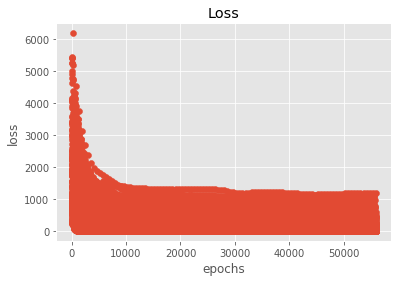

In [68]:
plt.close('all')
plt.title('Loss')
plt.scatter(x=np.arange(0,len(loss_list)),y=loss_list)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

Well, that looks very different from the results he got, but he was predicting the Euro-USD exchange rate, not a stock, and it's possible that the network he set up was better suited to do that (or simply that there's more variability in a company's stock than most exchange rates).

Specifically, the `loss_list` has 559 values for every epoch in the training data.  According to the output of the cell above that begins '`# TF Hyperparams`':

    The current configuration gives us 559 batches of 1 observations each one looking 3 steps in the past
    
That was determined by dividing the variables `total_series_length//batch_size//truncated_backprop_length`'.  Total series length is just the number of rows (dates, here, with values for MACD, stochastic oscillator %K, and ATR) in the training data; `batch_size` is 1, and `truncated_backprop_length` (apparently the number of consecutive dates to consider) is 3.  So each datum in the loss list is a batch; the disagreement between the output of the network for three consecutive days of MACD, %K, and ATR values, and the label (the MSFT price for the following day).

I don't know whether it is meaningful that the loss output is numerically different than what `alberduris` saw; his values were all less than 1, but he normalized his labels prior to training, whereas I did not.

In [69]:
X_train.shape
X_train.head()

,MACD,stoch_%K,ATR
2015-06-04,0.294693,-1.563927,0.435214
2011-07-08,0.774694,1.231842,-0.567825
2015-09-14,-1.437350,0.512699,-0.260772
2014-07-07,0.443781,0.249545,-0.690646
2008-06-18,-0.432026,0.357268,-0.711116


In [70]:
# Set TF Hyperparams

num_epochs = 100

batch_size = 1

total_series_length = X_train.shape[0]

truncated_backprop_length = 3   # The size of the sequence

state_size = 12   # The number of neurons

num_features = 3
num_classes = 1   # [1,0]

num_batches = total_series_length//batch_size//truncated_backprop_length

min_test_size = 100

print('The total series length is: %d' %total_series_length)
print('The current configuration gives us %d batches of %d observations each one looking %d steps in the past' 
      %(num_batches,batch_size,truncated_backprop_length))

The total series length is: 1677
The current configuration gives us 559 batches of 1 observations each one looking 3 steps in the past


In [71]:
loss_list[-12:]
len(loss_list)/1000

55.9

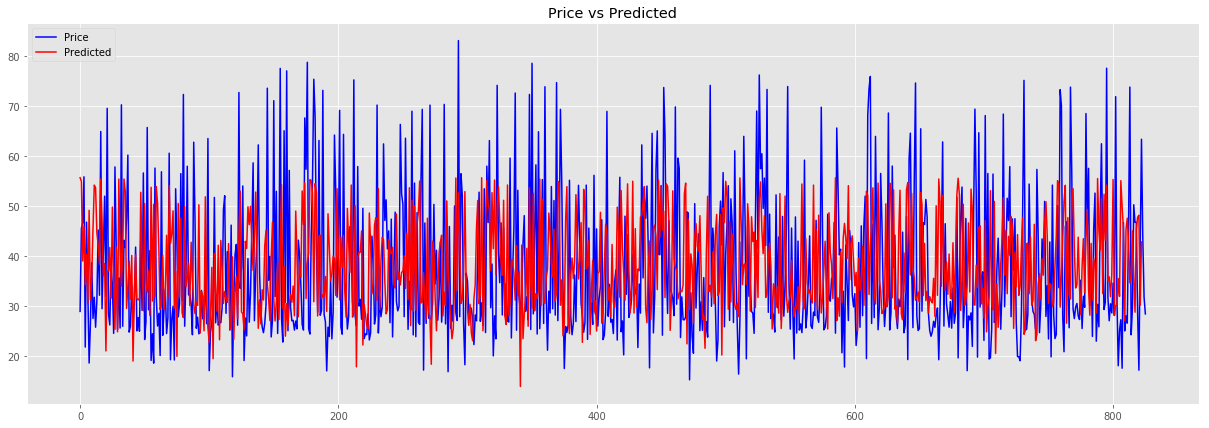

In [72]:
plt.close('all')
plt.figure(figsize=(21,7))
plt.plot(y_test.values, label='Price', color='blue')
plt.plot(test_pred_list, label='Predicted', color='red')
plt.title('Price vs Predicted')
plt.legend(loc='upper left')
plt.show()

In [73]:
tf_dir_pc = r'C:\Users\DMacKellar\Dropbox\Coding\Python\Sirajology\\
20170908_Stock_market_prediction\tf_models'

tf_dir_mac = '/Users/drew/Dropbox/Coding/Python/Sirajology/\
20170908_Stock_market_prediction/tf_models'

# on PC:
tf_dir = tf_dir_pc
# on Mac:
# tf_dir = tf_dir_mac

# writer = tf.summary.FileWriter(tf_dir_pc)
# writer.add_graph(sess.graph)

Another approach to setting up tensorboard with an RNN comes from demo code from a [Youtube video](https://www.youtube.com/watch?v=aypf1ltay4k):

cost:  12.1171
cost:  5.2253
cost:  1.408
cost:  0.9012
cost:  0.6547
cost:  0.3107
cost:  0.0709
cost:  0.0224
cost:  0.0314
cost:  0.0278


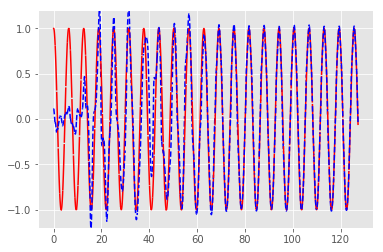

In [74]:
# View more python learning tutorial on my Youtube and Youku channel!!!

# Youtube video tutorial: https://www.youtube.com/channel/UCdyjiB5H8Pu7aDTNVXTTpcg
# Youku video tutorial: http://i.youku.com/pythontutorial

"""
Please note, this code is only for python 3+. If you are using python 2+, please modify the code accordingly.

Run this script on tensorflow r0.10. Errors appear when using lower versions.
"""
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


BATCH_START = 0
TIME_STEPS = 20
BATCH_SIZE = 50
INPUT_SIZE = 1
OUTPUT_SIZE = 1
CELL_SIZE = 10
LR = 0.006


def get_batch():
    global BATCH_START, TIME_STEPS
    # xs shape (50batch, 20steps)
    xs = np.arange(BATCH_START, BATCH_START+TIME_STEPS*BATCH_SIZE).reshape((BATCH_SIZE, TIME_STEPS)) / (10*np.pi)
    seq = np.sin(xs)
    res = np.cos(xs)
    BATCH_START += TIME_STEPS
    # plt.plot(xs[0, :], res[0, :], 'r', xs[0, :], seq[0, :], 'b--')
    # plt.show()
    # returned seq, res and xs: shape (batch, step, input)
    return [seq[:, :, np.newaxis], res[:, :, np.newaxis], xs]


class LSTMRNN(object):
    def __init__(self, n_steps, input_size, output_size, cell_size, batch_size):
        self.n_steps = n_steps
        self.input_size = input_size
        self.output_size = output_size
        self.cell_size = cell_size
        self.batch_size = batch_size
        with tf.name_scope('inputs'):
            self.xs = tf.placeholder(tf.float32, [None, n_steps, input_size], name='xs')
            self.ys = tf.placeholder(tf.float32, [None, n_steps, output_size], name='ys')
        with tf.variable_scope('in_hidden'):
            self.add_input_layer()
        with tf.variable_scope('LSTM_cell'):
            self.add_cell()
        with tf.variable_scope('out_hidden'):
            self.add_output_layer()
        with tf.name_scope('cost'):
            self.compute_cost()
        with tf.name_scope('train'):
            self.train_op = tf.train.AdamOptimizer(LR).minimize(self.cost)

    def add_input_layer(self,):
        l_in_x = tf.reshape(self.xs, [-1, self.input_size], name='2_2D')  # (batch*n_step, in_size)
        # Ws (in_size, cell_size)
        Ws_in = self._weight_variable([self.input_size, self.cell_size])
        # bs (cell_size, )
        bs_in = self._bias_variable([self.cell_size,])
        # l_in_y = (batch * n_steps, cell_size)
        with tf.name_scope('Wx_plus_b'):
            l_in_y = tf.matmul(l_in_x, Ws_in) + bs_in
        # reshape l_in_y ==> (batch, n_steps, cell_size)
        self.l_in_y = tf.reshape(l_in_y, [-1, self.n_steps, self.cell_size], name='2_3D')

    def add_cell(self):
        lstm_cell = tf.contrib.rnn.BasicLSTMCell(self.cell_size, forget_bias=1.0, state_is_tuple=True)
        with tf.name_scope('initial_state'):
            self.cell_init_state = lstm_cell.zero_state(self.batch_size, dtype=tf.float32)
        self.cell_outputs, self.cell_final_state = tf.nn.dynamic_rnn(
            lstm_cell, self.l_in_y, initial_state=self.cell_init_state, time_major=False)

    def add_output_layer(self):
        # shape = (batch * steps, cell_size)
        l_out_x = tf.reshape(self.cell_outputs, [-1, self.cell_size], name='2_2D')
        Ws_out = self._weight_variable([self.cell_size, self.output_size])
        bs_out = self._bias_variable([self.output_size, ])
        # shape = (batch * steps, output_size)
        with tf.name_scope('Wx_plus_b'):
            self.pred = tf.matmul(l_out_x, Ws_out) + bs_out

    def compute_cost(self):
        losses = tf.contrib.legacy_seq2seq.sequence_loss_by_example(
            [tf.reshape(self.pred, [-1], name='reshape_pred')],
            [tf.reshape(self.ys, [-1], name='reshape_target')],
            [tf.ones([self.batch_size * self.n_steps], dtype=tf.float32)],
            average_across_timesteps=True,
            softmax_loss_function=self.ms_error,
            name='losses'
        )
        with tf.name_scope('average_cost'):
            self.cost = tf.div(
                tf.reduce_sum(losses, name='losses_sum'),
                self.batch_size,
                name='average_cost')
            tf.summary.scalar('cost', self.cost)

    def ms_error(self, labels, logits):
        return tf.square(tf.subtract(labels, logits))

    def _weight_variable(self, shape, name='weights'):
        initializer = tf.random_normal_initializer(mean=0., stddev=1.,)
        return tf.get_variable(shape=shape, initializer=initializer, name=name)

    def _bias_variable(self, shape, name='biases'):
        initializer = tf.constant_initializer(0.1)
        return tf.get_variable(name=name, shape=shape, initializer=initializer)


if __name__ == '__main__':
    model = LSTMRNN(TIME_STEPS, INPUT_SIZE, OUTPUT_SIZE, CELL_SIZE, BATCH_SIZE)
    sess = tf.Session()
    merged = tf.summary.merge_all()
    writer = tf.summary.FileWriter("logs", sess.graph)
    # tf.initialize_all_variables() no long valid from
    # 2017-03-02 if using tensorflow >= 0.12
    if int((tf.__version__).split('.')[1]) < 12 and int((tf.__version__).split('.')[0]) < 1:
        init = tf.initialize_all_variables()
    else:
        init = tf.global_variables_initializer()
    sess.run(init)
    # relocate to the local dir and run this line to view it on Chrome (http://0.0.0.0:6006/):
    # $ tensorboard --logdir='logs'

    plt.ion()
    plt.show()
    for i in range(200):
        seq, res, xs = get_batch()
        if i == 0:
            feed_dict = {
                    model.xs: seq,
                    model.ys: res,
                    # create initial state
            }
        else:
            feed_dict = {
                model.xs: seq,
                model.ys: res,
                model.cell_init_state: state    # use last state as the initial state for this run
            }

        _, cost, state, pred = sess.run(
            [model.train_op, model.cost, model.cell_final_state, model.pred],
            feed_dict=feed_dict)

        # plotting
        plt.plot(xs[0, :], res[0].flatten(), 'r', xs[0, :], pred.flatten()[:TIME_STEPS], 'b--')
        plt.ylim((-1.2, 1.2))
        plt.draw()
        plt.pause(0.3)

        if i % 20 == 0:
            print('cost: ', round(cost, 4))
            result = sess.run(merged, feed_dict)
            writer.add_summary(result, i)

I don't really like the whole 'define-a-class-and-call-if-main' code philosophy here, though.

Yet another one is a [TensorBoard-enhanced RNN](https://github.com/ubergarm/TensorFlow-Examples/blob/55cbb507ded60e9deb7c7da2fd3a0a16a22c8ef7/examples/3_NeuralNetworks/recurrent_network.py) for MNIST classification.  I'll try rebuilding around that code, briefly:

In [75]:
import os
import tensorflow as tf
from tensorflow.contrib import rnn

# Where to store data, save models, and write tensorboard logs
MAINDIR = tf_dir
DATADIR = data_dir
MODELDIR = os.path.join(tf_dir, "models")
LOGDIR = os.path.join(tf_dir, "logs")

# Parameters
learning_rate = 0.001
training_iters = 1000
batch_size = 1
display_step = 5
save_step = 100

# Network Parameters
n_input = 3 # data input (technical analysis features)
n_steps = 3 # timesteps
n_hidden = 12 # hidden layer num of features
n_classes = 1 # network is a regressor, not classifier

# tf Graph input
with tf.name_scope('input'):
    x = tf.placeholder("float", shape=[None, n_steps, n_input], 
                       name='predictors')
    y = tf.placeholder("float", shape=[None, 1], 
                       name='labels')

# Define weights
with tf.name_scope("hidden_layer"):
    weights = {
        'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([n_classes]))
    }
    tf.summary.histogram("weights", weights['out'])
    tf.summary.histogram("biases", biases['out'])

def RNN(x, weights, biases):
    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)

    # Permuting batch_size and n_steps
    x = tf.transpose(x, [1, 0, 2])
    # Reshaping to (n_steps*batch_size, n_input)
    x = tf.reshape(x, [-1, n_input])
    # Split to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.split(x, n_steps, 0)

    # Define a lstm cell with tensorflow
    with tf.variable_scope('lstm_cell'):
        lstm_cell = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)#, reuse=True)   # DCM edit to add reuse=True

    # Get lstm cell output
    with tf.variable_scope('lstm_output'):
        outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    act = tf.matmul(outputs[-1], weights['out']) + biases['out']
    tf.summary.histogram("activations", act)
    return act

pred = RNN(x, weights, biases)

# Define loss and optimizer
with tf.name_scope('cost'):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits=pred, labels=y), name='cost')
    tf.summary.scalar('cost', cost)

with tf.name_scope('optimizer'):
    optimizer = tf.train.AdamOptimizer(
        learning_rate=learning_rate, name='other').minimize(cost)
#     tf.summary.tensor_summary('optim', optimizer)

# Evaluate model
with tf.name_scope("accuracy"):
    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    tf.summary.scalar("accuracy", accuracy)

# tensorboard instrumentation
summ = tf.summary.merge_all()
saver = tf.train.Saver()

# Initializing the variables
init = tf.global_variables_initializer()

# Launch the graph
with tf.Session() as sess:
    sess.run(init)

    writer = tf.summary.FileWriter(LOGDIR)
    writer.add_graph(sess.graph)

    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y = next(X_train.itertuples()), next(y_train.iteritems())
        # Reshape data to get 28 seq of 28 elements
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        if step % display_step == 0:
            # Calculate batch accuracy
            [acc, s] = sess.run([accuracy, summ], feed_dict={x: batch_x, y: batch_y})
            writer.add_summary(s, step)
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
            print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        if step % save_step == 0:
            print("Saving model checkpoint after {} steps.".format(step))
            saver.save(sess, os.path.join(MODELDIR, "model.ckpt"), step)
        step += 1
    print("Optimization Finished!")

    # Calculate accuracy for 128 mnist test images
#     test_len = 128
#     test_data = mnist.test.images[:test_len].reshape((-1, n_steps, n_input))
#     test_label = mnist.test.labels[:test_len]

    test_len = len(X_test)
    test_data = X_test
    test_label = y_test
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: test_data, y: test_label}))

AttributeError: 'Pandas' object has no attribute 'reshape'

In [ ]:
print(type(next(X_train.iterrows())))
print(type(next(y_train.iteritems())))
print(type(X_train))
print(next(X_train.iterrows()))
print(type(next(X_train.itertuples())))

In [ ]:
for x in X_train.iloc[0]:
    print(x, type(x))

In [ ]:
# rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
# rnn.BasicLSTMCell()
X_train.head()
y_train.head()

In [ ]:
X_test[test_idx:test_idx+truncated_backprop_length:].values.reshape((1,truncated_backprop_length,num_features))

In [ ]:
term_out_lines[:13]

In [ ]:
import string
import nltk
import random

dir(nltk)
blake = nltk.corpus.gutenberg.words('blake-poems.txt')
len(blake)
ind = list(string.ascii_lowercase[:10:1])
cols = random.choices(blake, k=10)
test = pd.DataFrame(data=np.random.rand(10, 10), index=ind, columns=cols)

# print(ind)
# blah = ''

# ' '.join(term_out_lines[1].split()[:2])

# pd.DataFrame()
test.head()

In [ ]:
# test['in']['a']
# epoch[0]
# values.index[0]
# values.index[0] == epoch[0]
# list(range(0, len(term_out_lines), 13))[:20]
# test['d']['keep']
epoch[-1]

In [ ]:
1/15

# Another stupid problem

Ok, so I understood that the newer versions of Tensorflow are more amenable to setting up summaries with Tensorboard, and maybe even building standard classes of models like RNNs.  As of 20171012, [Tensorflow is up to v1.4](https://www.tensorflow.org/), whereas I still have v1.0 installed on the PC.

So I tried installing a new version with pip, but pip complains about an unexpected arg:

    TypeError: parse() got an unexpected keyword argument 'transport_encoding'
    
[Stackoverflow responses](https://stackoverflow.com/questions/46528671/transport-encoding-error-during-installing-with-pip) suggested that this is due to Tensorflow screwing up the version of html5lib upon install.  They suggested uninstalling and reinstalling this library with conda, which I did, but this had no effect as I had two versions installed, one via conda and one via pip (the conda one was already up-to-date); apparently pip relies upon the one installed using pip specifically.

So I did `pip uninstall html5lib`, then went to reinstall it, but it turns out that pip itself requires that library, and won't work at all without it:

    pip ImportError: cannot import name 'html5lib'
    
So now I need to reinstall pip, but no simple way of doing this exists for the pc; everybody just says 'it comes packaged with python; no need'.  So now I have to uninstall and reinstall Anaconda AGAIN.  Then pip install every stupid package to get back where I was.  THEN install the new Tensorflow, with now dependencies, then manually grab any dependencies OTHER THAN HTML5LIB.  God dang this crap.

...Ok, apparently reinstalling Anaconda wasn't totally necessary.  After reinstalling it and then installing the Tensorflow v1.4 wheel that I'd previously downloaded, it still screwed up html5lib (I'd forgotten to specify the '`no-dep`' flag upon installing tf), and pip was broken again.  I resolved it by [doing '`conda install -c anaconda pip`'](https://anaconda.org/anaconda/pip) to get a working version of pip back.  Then I did '`conda install -c anaconda html5lib`', which got it back to a version that would work with pip (btw, the assholes who make html5lib insist that they're never going to release a version 1.0, so the broken version is 'v0.99999999' and the working version is 'v0.999999999999' or some junk, making it impossible to tell whether your version will work until you try pip).  Now I think that I have the new Tensorflow, along with pip working.

Alternatively, apparently you can [manually download html5lib](https://github.com/tensorflow/tensorboard/issues/588#issuecomment-335362968) and call '`pip install`' on the local wheel, which maybe avoids importing html5lib, since it doesn't have to go online to get the wheel.

Anyways, I'm still having problem with the naming conventions in tensorboard and the above code for an RNN.  I'm going to have to dig deeper if I'm gonna succeed at personalizing and getting this to work.  [This article](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) seems useful to getting a handle on the specifics of how the RNN is set up.

In [ ]:
X_train.shape

In [ ]:
type(y_train[0])